# **MONTHLY PURCHASE PREDICTION FOR E-COMMERCE**

**Created by :**<br>
Nathania Frieska Zamris (JCDS 0106 002)<br>
Mary Amalia Wauran (JCDS 0106 006)<br>
Idam Ahmadi (JCDS 0106 007)<br>

## **Business Problem Understanding**

### Background

We work as members of a **data scientist** team at a company called **Olist E-Commerce** with a *revenue model* that involves **profit-sharing** from sales made by *sellers* within the platform.

**Olist E-Commerce** is a Brazilian online marketplace that connects merchants (small and medium-sized businesses) with customers throughout Brazil. Merchants can use Olist to sell their products online and access a wider market share, logistics services, and payment processing solutions.

### Problem Statement

Our team was asked by the **marketing team** to **predict** the amount of purchase value or **Total Item Value (TIV)** that will occur in the **next 4 months** (by the end of 2018), based on the company's historical data from 2016-2018.

### Goals

The purpose of making the prediction is to give the marketing team an idea of how much TIV can be achieved by the end of the year and help them determine the **budget** needed to reach that TIV.

Here we also provide some recommendations both from the marketing and non-marketing perspective, based on the data insights we have found, including :

1. How to increase Retention and Average Basket Size (ABS)?
1. What are the performance and potential of the city?
1. What are the potential and obstacles of the best-selling product?
1. How to improve service in line with the increasing number of transactions?
1. Is there any other potential that can be used as product diversification?

*Note: The analysis we conducted is only surface-level and needs to be examined further*

---
## **Data Understanding**

### Dataset Information

**Brazilian E-Commerce Public Dataset**
- Source : [kaggle.com](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_products_dataset.csv)
- Authors : Olist and André Sionek
- Year : 2018

This dataset is a public dataset from the Olist e-commerce company for the years 2016-2018, which consists of :
- Customer dataset
- Order items dataset
- Order payments dataset
- Orders dataset
- Products dataset
- Product category dataset

### Attribute Information

Information of the data used :

| Attribute | Data Type | Description |
| --- | --- | --- |
| order_id | String | Unique identifier of the order |
| product_id | String | Unique product identifier |
| purchase | Float | Item price |
| order_status | String | Reference to the order status (delivered, shipped, etc) |
| product_category_name_english | String | Category name in English |
| customer_unique_id | String | Unique identifier of a customer |
| customer_city | String | Customer city name |
| customer_state | String | Customer state |
| payment_type | String | Method of payment chosen by the customer |
| month | Period[M] | Year and month of order |
| date | Period[D] | Year, month, and date of order |

### Evaluation Metric

Evaluation metrics that will be used are MAE, MAPE, MSE, and RMSE.

- MAE (Mean Absolute Error) is an evaluation metric used to assess model performance. MAE measures the average absolute error between predicted and actual values. MAE is calculated by adding up the absolute errors for each prediction and then dividing by the total number of predictions.

- MAPE (Mean Absolute Percentage Error) is a similar evaluation metric to MAE, but using absolute percentage errors. MAPE measures the average absolute error as a percentage of the actual value. MAPE is useful when the data scale is different, so giving absolute errors in the same unit is not meaningful enough.

- MSE (Mean Squared Error) is another evaluation metric that measures the average squared error between predicted and actual values. MSE is calculated by adding up the squared errors for each prediction and then dividing by the total number of predictions.

- RMSE (Root Mean Squared Error) is a similar evaluation metric to MSE, but taking the square root of the MSE value. RMSE provides an easier-to-interpret measure of error in the same unit as the target variable. RMSE also gives more weight to larger errors, which may be more important in some cases.

All of these evaluation metrics are useful for comparing the performance of different models and selecting the best model for a given case. However, each evaluation metric has its own strengths and weaknesses, so the choice depends on business objectives and data characteristics.

**MAPE**

We decided to use MAPE as the evaluation metric for several reasons :

- Our graph has significantly different trends, so using nominal error evaluation of 10000 in 2017 might be large but small in 2018, whereas with MAPE such perception differences can be avoided.
- MAPE is easier to understand for the marketing team.

---
## **Data Cleaning and Preprocessing**

### Data Cleaning

#### Import Library

In [213]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from datetime import date
from datetime import datetime
from datetime import timedelta

import sklearn.metrics as metrics

import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from prophet import Prophet

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from PIL import Image

pd.set_option('display.max_columns', 50)

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### Load Dataset

In [214]:
# Load any required datasets
customer = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
categories = pd.read_csv("product_category_name_translation.csv")

#### Merge Dataset

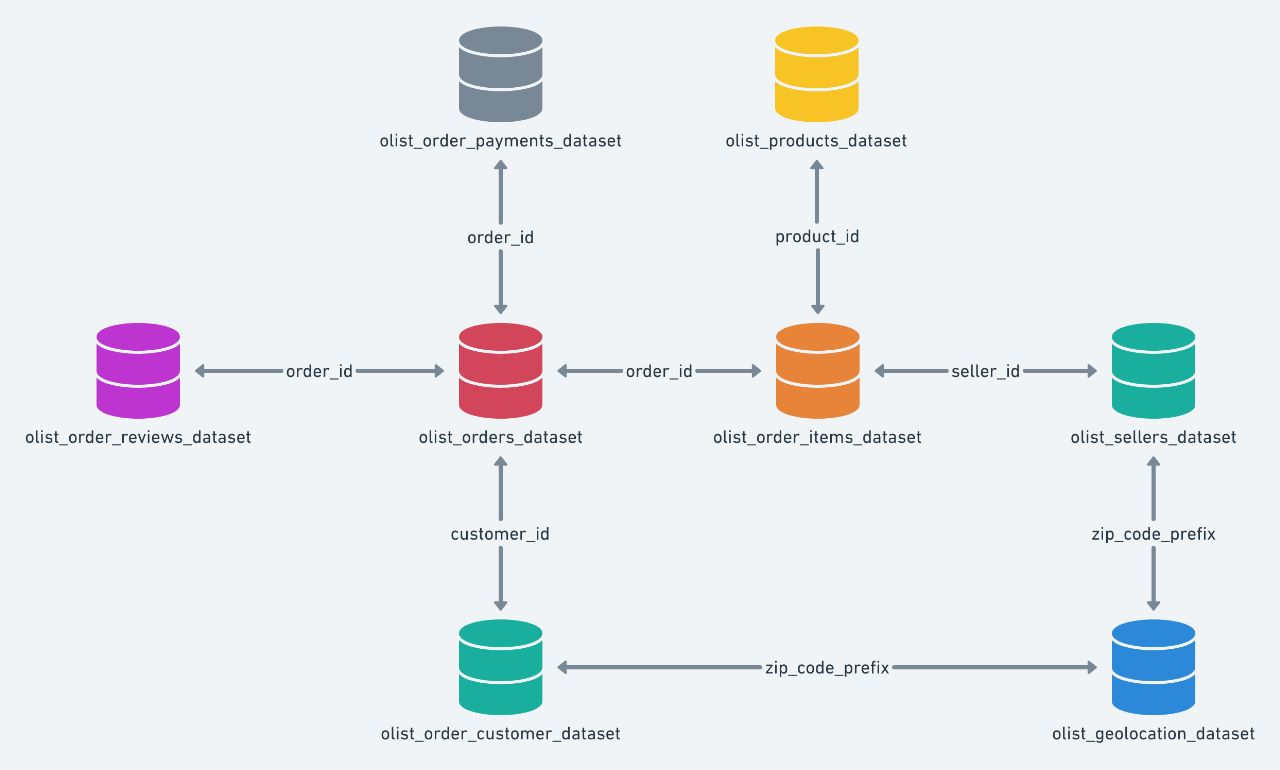

In [215]:
# View the related columns between datasets
from IPython.display import Image
Image('dataset.jpg')

In [216]:
# Combine the datasets to be used
df_orders = order_items.merge(orders, on='order_id').merge(products, on='product_id').merge(categories, on='product_category_name').merge(customer, on='customer_id').merge(order_payments, on='order_id')

# Changed the order_purchase_timestamp data type to be period in datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['month'] = df_orders['order_purchase_timestamp'].dt.to_period('M')
df_orders['date'] = df_orders['order_purchase_timestamp'].dt.to_period('D')

# Rename column price to purchase
df_orders.rename(columns={'price':'purchase'},inplace=True)

# Handling duplicate data
if df_orders.duplicated().sum() == 0:
    print('No duplicate data found')
else:
    print(f'Successfully dropped {df_orders.duplicated().sum()} duplicates')
    df_orders.drop_duplicates(inplace=True)

No duplicate data found


### Exploratory Data Analysis and Preprocessing

In [217]:
# Column and data type information
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   order_item_id                  115878 non-null  int64         
 2   product_id                     115878 non-null  object        
 3   seller_id                      115878 non-null  object        
 4   shipping_limit_date            115878 non-null  object        
 5   purchase                       115878 non-null  float64       
 6   freight_value                  115878 non-null  float64       
 7   customer_id                    115878 non-null  object        
 8   order_status                   115878 non-null  object        
 9   order_purchase_timestamp       115878 non-null  datetime64[ns]
 10  order_approved_at              115864 non-null  object        
 11  

In [218]:
# The required column
df_orders = df_orders[[
    'order_id',                       
    'product_id',                     
    'purchase',                       
    'order_status',                    
    'product_category_name_english',  
    'customer_unique_id',             
    'customer_city',                  
    'customer_state',                 
    'payment_type',                    
    'order_purchase_timestamp',                 
    'month',                          
    'date',                                                               
]]
df_orders.head(1)

,order_id,product_id,purchase,order_status,product_category_name_english,customer_unique_id,customer_city,customer_state,payment_type,order_purchase_timestamp,month,date
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,delivered,cool_stuff,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,credit_card,2017-09-13 08:59:02,2017-09,2017-09-13


In [219]:
# Information of df_orders data that will be used in analysis and modeling.
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   product_id                     115878 non-null  object        
 2   purchase                       115878 non-null  float64       
 3   order_status                   115878 non-null  object        
 4   product_category_name_english  115878 non-null  object        
 5   customer_unique_id             115878 non-null  object        
 6   customer_city                  115878 non-null  object        
 7   customer_state                 115878 non-null  object        
 8   payment_type                   115878 non-null  object        
 9   order_purchase_timestamp       115878 non-null  datetime64[ns]
 10  month                          115878 non-null  period[M]     
 11  

In [220]:
# Missing value information
df_orders.isna().sum()

# There is no missing value, all data is complete

order_id                         0
product_id                       0
purchase                         0
order_status                     0
product_category_name_english    0
customer_unique_id               0
customer_city                    0
customer_state                   0
payment_type                     0
order_purchase_timestamp         0
month                            0
date                             0
dtype: int64

In [221]:
# Unique of order status
df_orders['order_status'].unique()

array(['delivered', 'shipped', 'invoiced', 'canceled', 'processing',
       'unavailable', 'approved'], dtype=object)

In [222]:
# Exclude data with canceled and unavailable order status
df_orders = df_orders[(~(df_orders['order_status']=='canceled'))&(~(df_orders['order_status']=='unavailable'))]

print('The status of orders with "canceled" and "unavailable" statuses no longer exist')
df_orders['order_status'].unique()

The status of orders with "canceled" and "unavailable" statuses no longer exist


array(['delivered', 'shipped', 'invoiced', 'processing', 'approved'],
      dtype=object)

In [223]:
# Creating a purchase dataframe related to the date
# Purchase data grouped by month
df_ym = df_orders[['month','purchase']].groupby(by='month').sum()[['purchase']].reset_index()
df_ym.rename(columns={'month':'date'},inplace=True)

# Purchase data grouped by date
df_ymd = df_orders[['date','purchase']].groupby(by='date').sum()[['purchase']].reset_index()
df_ymd.rename(columns={'month':'date'},inplace=True)
df_ymd['year'] = df_ymd['date'].dt.year
df_ymd['month'] = df_ymd['date'].dt.month
df_ymd['day'] = df_ymd['date'].dt.day
df_ymd['weekday'] = df_ymd['date'].dt.weekday

# Data prophet
df_prophet = df_orders[['order_purchase_timestamp','purchase','date']]
df_prophet.columns = ['ds','y','date']

# Displaying the three data above
display(
    df_ym.head(),
    df_ymd.head(),
    df_prophet.head()
)

,date,purchase
0,2016-09,72.89
1,2016-10,45875.98
2,2016-12,10.90
3,2017-01,126720.75
4,2017-02,249329.29


,date,purchase,year,month,day,weekday
0,2016-09-04,72.89,2016,9,4,6
1,2016-10-03,441.98,2016,10,3,0
2,2016-10-04,10068.47,2016,10,4,1
3,2016-10-05,7116.16,2016,10,5,2
4,2016-10-06,6295.72,2016,10,6,3


,ds,y,date
0,2017-09-13 08:59:02,58.9,2017-09-13
1,2017-06-28 11:52:20,55.9,2017-06-28
2,2018-05-18 10:25:53,64.9,2018-05-18
3,2017-08-01 18:38:42,58.9,2017-08-01
4,2017-08-10 21:48:40,58.9,2017-08-10


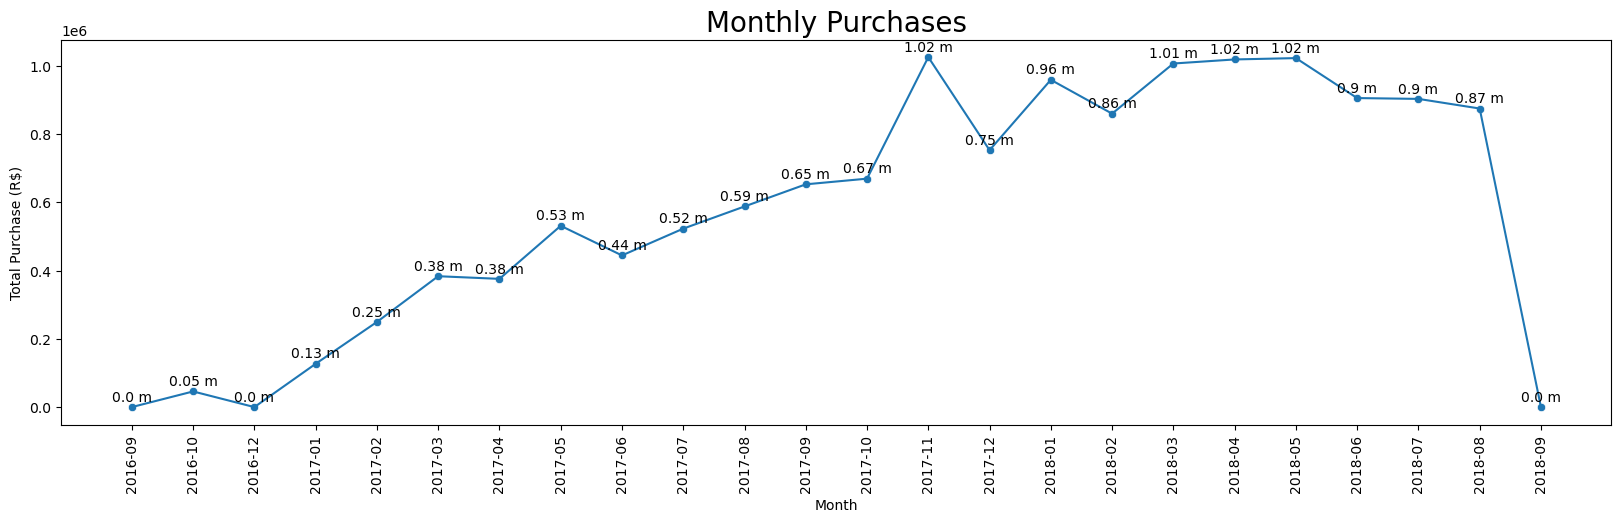

In [224]:
# Displaying the graph of the Total Purchases over 2 years (September 2016-September 2018)
# Converting date data type to string to create a line plot
df_monthly = df_ym.copy()
df_monthly['date'] = df_monthly['date'].astype(str)

# Creating line plot and scatter plot
plt.figure(figsize = (20,5))
ax = sns.lineplot(data = df_monthly, x='date', y='purchase')
sns.scatterplot(data = df_monthly, x='date', y='purchase')

# Adding annotation to the graph
for i, value in enumerate(df_monthly['purchase']):
    text = f'{round(value/1e6, 2)} m'
    ax.annotate(text, xy=(df_monthly['date'][i], value),
                xytext=(df_monthly['date'][i], value+50000),
                ha='center', va='top')

plt.xticks(rotation = 90)
plt.xticks(range(len(df_monthly)))
plt.title('Monthly Purchases', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')

plt.show()

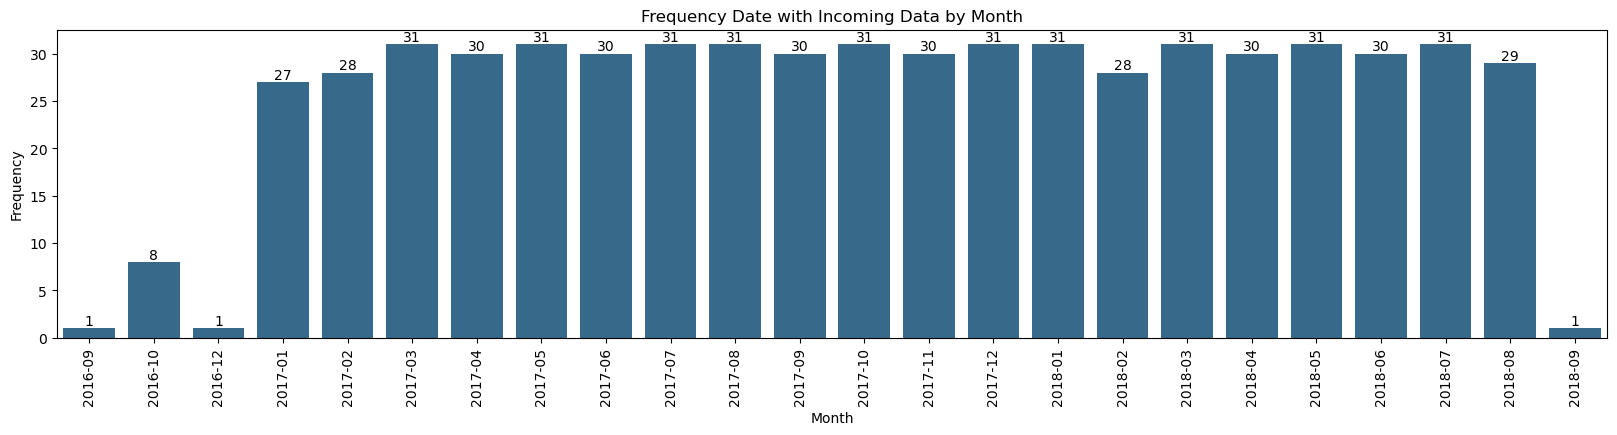

In [225]:
# Data completeness for each month
df_support = df_ym.copy()
df_support2 = df_ymd.groupby(by=['year','month']).count().reset_index()
df_support.insert(len(df_support.columns),'n_day',df_support2['date'])
df_support['date'] = df_support['date'].astype(str)

plt.figure(figsize = (20,4))
barplot = sns.barplot(data=df_support,x='date',y='n_day',color='#296d98')
plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))

for bar in barplot.containers:
    barplot.bar_label(bar, label_type='edge', labels=[ int(h) for h in bar.datavalues])

barplot.set(xlabel='Month', ylabel='Frequency',
       title='Frequency Date with Incoming Data by Month')
plt.show()

The graph above shows the number of purchases over 2 years **(September 2016 - September 2018)**
- The dataset contains September 2016 - September 2018 data
- There is no data at all in November 2016 
- Incomplete data in September, October, and December 2016
- Data entered only 1 day in September 2018

So, September-December 2016 and September 2018 data will not be used for analysis or modeling

In [226]:
# Removing incomplete data
df_orders = df_orders[(df_orders['month']>='2017-01')&(df_orders['month']<'2018-09')]

#### Monthly Purchases

In [227]:
# Creating a new dataframe : Aggregating data by month
df_ym = df_orders[['month','purchase']].groupby(by='month').sum()[['purchase']].reset_index()
df_ym.rename(columns={'month':'date'},inplace=True)

# Creating a new dataframe : Aggregating data by date
df_ymd = df_orders[['date','purchase']].groupby(by='date').sum()[['purchase']].reset_index()
df_ymd.rename(columns={'month':'date'},inplace=True)
df_ymd['year'] = df_ymd['date'].dt.year
df_ymd['month'] = df_ymd['date'].dt.month
df_ymd['day'] = df_ymd['date'].dt.day
df_ymd['weekday'] = df_ymd['date'].dt.weekday

# Creating a dataframe for modeling using fbprophet
df_prophet = df_orders[['order_purchase_timestamp','purchase','date']]
df_prophet.columns = ['ds','y','date']

# Displaying the three dataframes above
display(
    df_ym.head(),
    df_ymd.head(),
    df_prophet.head()
)

,date,purchase
0,2017-01,126720.75
1,2017-02,249329.29
2,2017-03,383283.91
3,2017-04,375531.37
4,2017-05,530888.38


,date,purchase,year,month,day,weekday
0,2017-01-05,396.90,2017,1,5,3
1,2017-01-06,3460.38,2017,1,6,4
2,2017-01-07,1351.90,2017,1,7,5
3,2017-01-08,709.58,2017,1,8,6
4,2017-01-09,673.79,2017,1,9,0


,ds,y,date
0,2017-09-13 08:59:02,58.9,2017-09-13
1,2017-06-28 11:52:20,55.9,2017-06-28
2,2018-05-18 10:25:53,64.9,2018-05-18
3,2017-08-01 18:38:42,58.9,2017-08-01
4,2017-08-10 21:48:40,58.9,2017-08-10


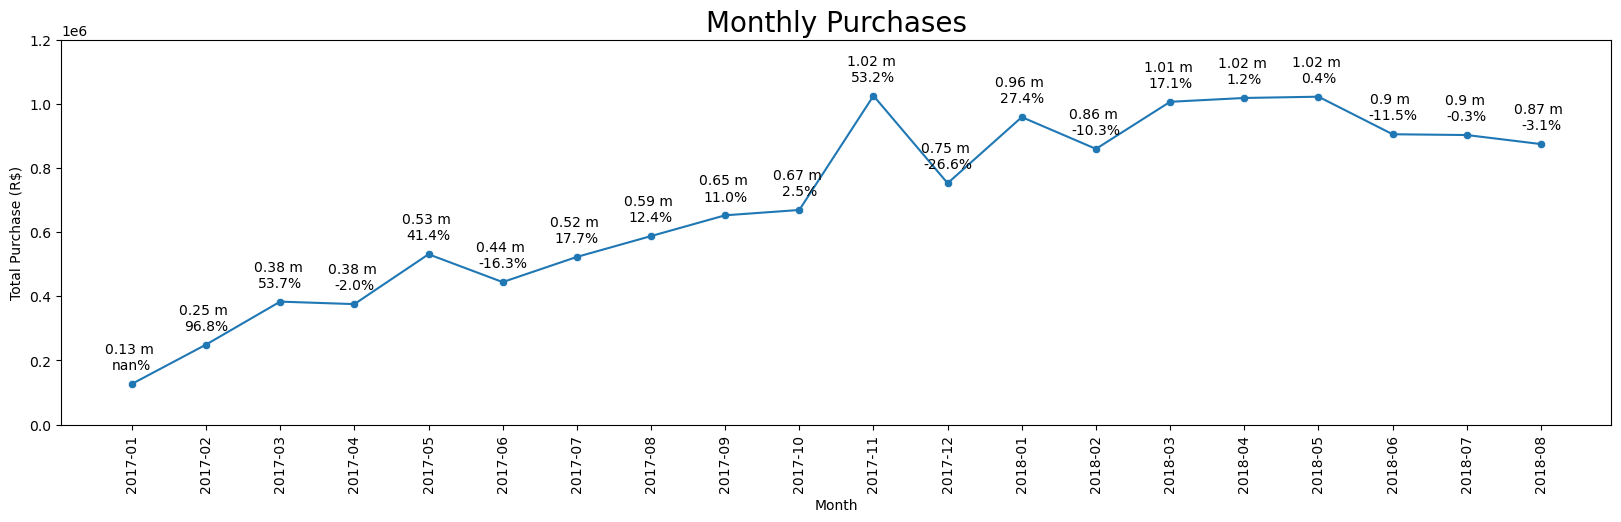

In [228]:
# Creating a monthly purchases graph
df_monthly = df_ym.copy()
df_monthly['date'] = df_monthly['date'].astype(str)

# Adding a new column to the dataframe
df_monthly['pct_change'] = df_monthly['purchase'].pct_change() * 100

plt.figure(figsize = (20,5))
ax = sns.lineplot(data = df_monthly, x='date', y='purchase')
sns.scatterplot(data = df_monthly, x='date', y='purchase')
plt.yticks(ticks=range(0,1400000,200000))

# Adding annotation to the graph
for i, value in enumerate(df_monthly['purchase']):
    text = f'''{round(value/1e6, 2)} m 
{round(df_monthly["pct_change"][i], 1)}%'''
    ax.annotate(text, xy=(df_monthly['date'][i], value),
                xytext=(df_monthly['date'][i], value+130000),
                ha='center', va='top')

plt.xticks(rotation = 90)
plt.xticks(range(len(df_monthly)))
plt.title('Monthly Purchases', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')

plt.show()

In [229]:
# Monthly Purchases
df_monthly

,date,purchase,pct_change
0,2017-01,126720.75,NaN
1,2017-02,249329.29,96.754904
2,2017-03,383283.91,53.725986
3,2017-04,375531.37,-2.022663
4,2017-05,530888.38,41.369915
5,2017-06,444194.14,-16.330032
6,2017-07,522608.10,17.653083
7,2017-08,587550.63,12.426621
8,2017-09,652353.58,11.029339
9,2017-10,668953.61,2.544637


Based on the graph above, it can be seen that:
- Monthly purchases tend to increase
- The highest total purchases occurred in November 2017, which amounted to 1.024.942 R$
- The lowest total purchases occurred in January 2017, which was 126.720 R$
- The total purchases experienced a significant increase of 53,2% in November 2017
- Total purchases experienced a significant decrease of 26,6% in December 2017.

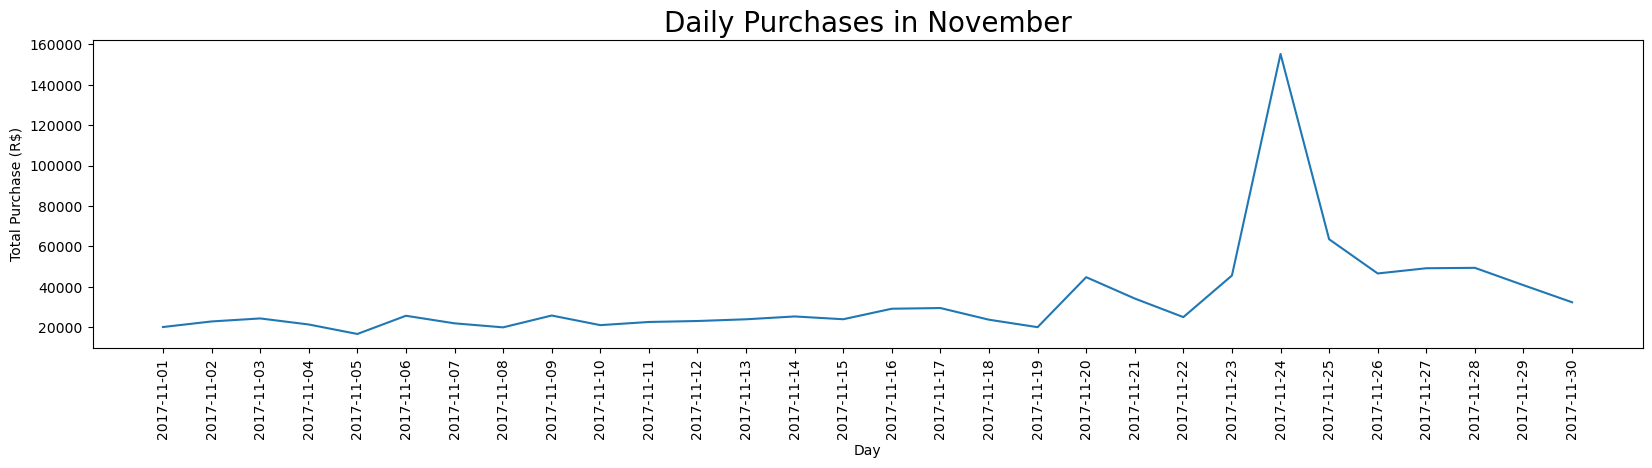

In [230]:
# The highest total purchases occurred in November 2017 
# Creating a daily purchases graph to see significant increases in purchases
df_support = df_ymd[(df_ymd['date']>='2017-11-01')&(df_ymd['date']<='2017-11-30')]
df_support['date'] = df_support['date'].astype(str)

plt.figure(figsize = (20,4))
sns.lineplot(data = df_support, x='date', y='purchase')
plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))

plt.title('Daily Purchases in November', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Day')
plt.show()

Apparently, there was an anomaly that occurred, and after investigating, it turns out that a Black Friday event happened on November 24-25. After looking at the graph, we decided to create a Black Friday feature for the dates between November 23-28.

In [231]:
# Adding a Black Friday feature
df_ymd['black_friday'] = (df_ymd['month']==11) & (df_ymd['day'].between(23,28))
df_ymd['black_friday'] = np.where(df_ymd['black_friday'] == True, 1, 0)
df_ymd

,date,purchase,year,month,day,weekday,black_friday
0,2017-01-05,396.90,2017,1,5,3,0
1,2017-01-06,3460.38,2017,1,6,4,0
2,2017-01-07,1351.90,2017,1,7,5,0
3,2017-01-08,709.58,2017,1,8,6,0
4,2017-01-09,673.79,2017,1,9,0,0
...,...,...,...,...,...,...,...
597,2018-08-25,10711.93,2018,8,25,5,0
598,2018-08-26,8235.71,2018,8,26,6,0
599,2018-08-27,4870.87,2018,8,27,0,0
600,2018-08-28,3757.51,2018,8,28,1,0


#### Quarterly Purchases

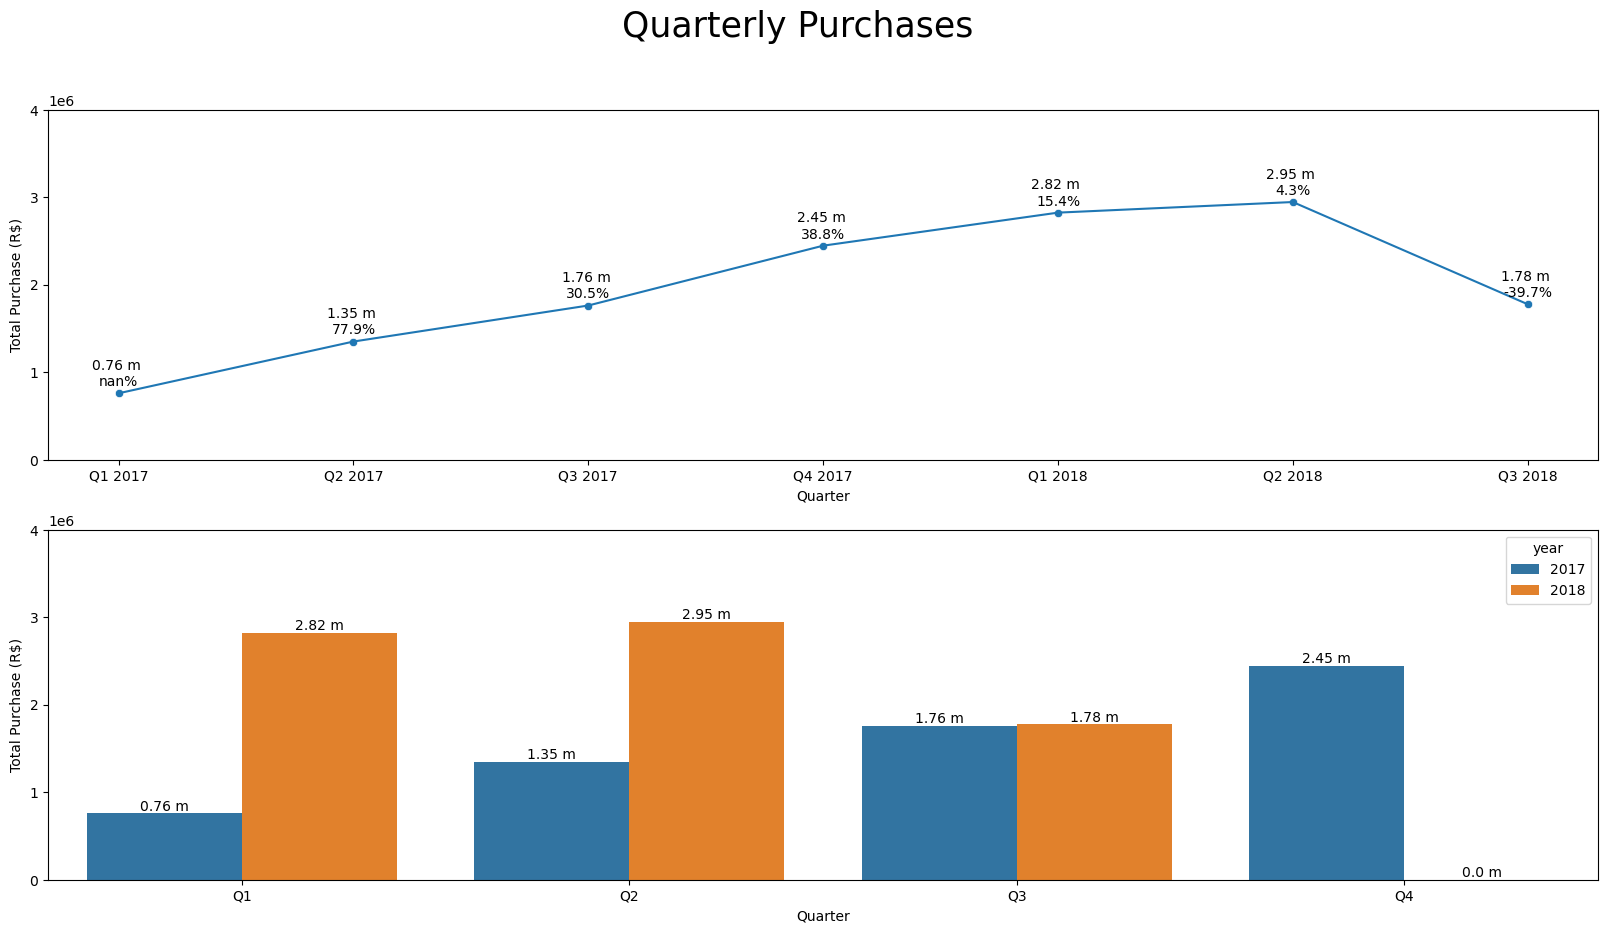

In [232]:
# Creating a quarter column by dividing the data based on quarters
df_ymd['quarter'] = (df_ymd['month'] - 1) // 3 + 1

# Creating a year_quarter column by combining the year and quarter columns
df_ymd['year_quarter'] = df_ymd['year'].astype(str) + '-Q' + df_ymd['quarter'].astype(str)

# Aggregating data based on year_quarter by summing up purchases
df_quarter = df_ymd.groupby('year_quarter')['purchase'].sum().reset_index()

# Adding a new column to the dataframe
df_quarter['pct_change'] = df_quarter['purchase'].pct_change() * 100

# Creating a line plot and bar plot
plt.figure(figsize=(20, 10))

## LINEPLOT
plt.subplot(2,1,1)
lineplot = sns.lineplot(data=df_quarter, x='year_quarter', y='purchase')
sns.scatterplot(data=df_quarter, x='year_quarter', y='purchase')
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Quarter')
labels = ['Q{} {}'.format(q, y) for y in range(df_ymd['year'].min(), df_ymd['year'].max() + 1) for q in range(1, 5)]
lineplot.set_xticklabels(labels=labels)
plt.yticks(ticks=range(0,5000000,1000000))

## Adding annotations to the line plot
for i, value in enumerate(df_quarter['purchase']):
    text = f'''{round(value/1e6, 2)} m 
{round(df_quarter["pct_change"][i], 1)}%'''
    lineplot.annotate(text, xy=(df_quarter['year_quarter'][i], value), 
                      xytext=(df_quarter['year_quarter'][i], value+50000),
                      ha='center', va='bottom')

## BARPLOT 
plt.subplot(2,1,2)
barplot = sns.barplot(data=df_ymd, x='quarter', y='purchase', hue='year', estimator=np.sum, errorbar=('ci',0))
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Quarter')
barplot.set_xticklabels(labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.yticks(ticks=range(0,5000000,1000000))

## Adding annotations to the bar plot
for bar in barplot.containers:
    barplot.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in bar.datavalues])


plt.suptitle('Quarterly Purchases', size=25)
plt.show()

In [233]:
# Quarterly Purchases
df_quarter

,year_quarter,purchase,pct_change
0,2017-Q1,759333.95,NaN
1,2017-Q2,1350613.89,77.868234
2,2017-Q3,1762512.31,30.497126
3,2017-Q4,2446292.51,38.795769
4,2018-Q1,2823884.35,15.435269
5,2018-Q2,2945032.57,4.290127
6,2018-Q3,1776893.22,-39.664735


Note: In Q3 of 2018, the data is incomplete as there is no data for September, causing a decrease in that quarter to be observed.

Based on the graph above, it can be seen that:
- The total purchases for each quarter has increased
- The highest total purchases occurred in Q2 2018, which amounted to 2.945.032 R$
- The lowest total purchases occurred in Q1 2017, which was 759.333 R$
- The total purchases experienced a significant increase of 77,9% in Q2 2017
- The total purchases experienced a significant decrease of 4,3% in Q2 2018.

---
## **Analytic Approach**

We will build a model that will help the company provide a purchase prediction tool, which will be useful for determining the marketing budget. Forecasting for the next 4 months will be done by trying modeling using Fbprophet, ARIMA, and Elastic Net. The metric used is MAPE, and the comparison of the graphs between the models will be used for evaluation.

## **Modeling**

### Evaluation Metric

Creating an *evaluation metric* function for the *regression model* that we will create

In [234]:
# Regression metrics
def regression_results(y_true, y_pred):

    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mean_absolute_percentage_error=metrics.mean_absolute_percentage_error(y_true, y_pred)  
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE: ', round(mean_absolute_percentage_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

    sns.scatterplot(y_pred,y_true-y_pred)

### Splitting Data

Splitting the train and test data with a ratio of 80:20 or 16:4 months

In [235]:
# Splitting the data into train and test data

# Reference for splitting the data is in May 2018
date_split = '2018-05'

# Train data: data before May 2018
# A total of 481 data or 79.9%
data_train = df_ymd[~(df_ymd['date']>=date_split)]
X_train = df_ymd[~(df_ymd['date']>=date_split)][['year','month','day','weekday']]
y_train = df_ymd[~(df_ymd['date']>=date_split)]['purchase']

# Test data: data in May 2018 and after
# A total of 121 data or 20.1%
data_test = df_ymd[(df_ymd['date']>=date_split)]
X_test = df_ymd[(df_ymd['date']>=date_split)][['year','month','day','weekday']]
y_test = df_ymd[(df_ymd['date']>=date_split)]['purchase']

# Displaying the result of splitting the data
display(
    X_train,
    y_train,
    X_test,
    y_test
)

,year,month,day,weekday
0,2017,1,5,3
1,2017,1,6,4
2,2017,1,7,5
3,2017,1,8,6
4,2017,1,9,0
...,...,...,...,...
476,2018,4,26,3
477,2018,4,27,4
478,2018,4,28,5
479,2018,4,29,6


0        396.90
1       3460.38
2       1351.90
3        709.58
4        673.79
         ...   
476    33308.94
477    41010.46
478    23570.74
479    20072.60
480    36181.80
Name: purchase, Length: 481, dtype: float64

,year,month,day,weekday
481,2018,5,1,1
482,2018,5,2,2
483,2018,5,3,3
484,2018,5,4,4
485,2018,5,5,5
...,...,...,...,...
597,2018,8,25,5
598,2018,8,26,6
599,2018,8,27,0
600,2018,8,28,1


481    34289.19
482    41057.03
483    42749.04
484    40265.53
485    28354.83
         ...   
597    10711.93
598     8235.71
599     4870.87
600     3757.51
601     1546.04
Name: purchase, Length: 121, dtype: float64

### Prophet (fbprophet) Time-Series Model

Fbprophet is an open-source library developed by Facebook for time series forecasting. It simplifies time series modeling for non-experts by using an additive regression model that combines several main components of a time series, including trend, seasonality, and holiday effects. Fbprophet can automatically detect the impact of holidays on a time series, resulting in more accurate predictions. It assumes that holiday effects on a time series are one-time (non-recurring) effects, meaning that they only occur on specific holiday dates and do not affect the time series on other days. To address this, Fbprophet adds an indicator variable that indicates whether a day is a holiday or not.

In [236]:
# Preparing data for training and testing using the FBProphet library to predict time series data
# Filtering the df_prophet dataframe to select data between January 2017 - August 2018
df_prophet = df_prophet[(df_prophet['date']>='2017-01') & (df_prophet['date']<'2018-09')]

# Creating training data for Prophet modeling
X_train_prophet = df_prophet[~(df_prophet['ds']>=date_split)][['ds','y']]
X_train_prophet['ds'] = X_train_prophet['ds'].dt.date
X_train_prophet = X_train_prophet.groupby(by='ds').sum().reset_index()

# Creating test data for Prophet modeling
X_test_prophet = df_prophet[(df_prophet['ds']>=date_split)][['ds','y']]
X_test_prophet['ds'] = X_test_prophet['ds'].dt.date
X_test_prophet = X_test_prophet.groupby(by='ds').sum().reset_index()

In [237]:
# The process of using the FBProphet library to predict time series data
prophet = Prophet()
prophet.fit(X_train_prophet)

df_support = prophet.predict(X_test_prophet)
yhat_pred = df_support['yhat']

data_test = df_ymd[(df_ymd['date']>=date_split)]

data_test.insert(len(data_test.columns),column='pred',value=yhat_pred.values)
df_support = data_test.groupby(by='month').sum()['pred'].reset_index()

data_pred = df_ym[(df_ym['date']>=date_split) & (df_ym['date']<'2018-09')].copy()
data_pred['pred'] = list(df_support['pred'])

# Calculating performance evaluation metrics for the model
prophet_metrics = regression_results(data_pred['purchase'], data_pred['pred'])
prophet_metrics

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\MARYAM~1\AppData\Local\Temp\tmpla_vea64\7yir2yzb.json
DEBUG:cmdstanpy:input tempfile: C:\Users\MARYAM~1\AppData\Local\Temp\tmpla_vea64\v98b0lr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Mary Amalia Wauran\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=93875', 'data', 'file=C:\\Users\\MARYAM~1\\AppData\\Local\\Temp\\tmpla_vea64\\7yir2yzb.json', 'init=C:\\Users\\MARYAM~1\\AppData\\Local\\Temp\\tmpla_vea64\\v98b0lr0.json', 'output', 'file=C:\\Users\\MARYAM~1\\AppData\\Local\\Temp\\tmpla_vea64\\prophet_modelp8fh1x5i\\prophet_model-2023050

MAE:  226795.1573
MAPE:  0.2508
MSE:  58933131843.1957
RMSE:  242761.4711


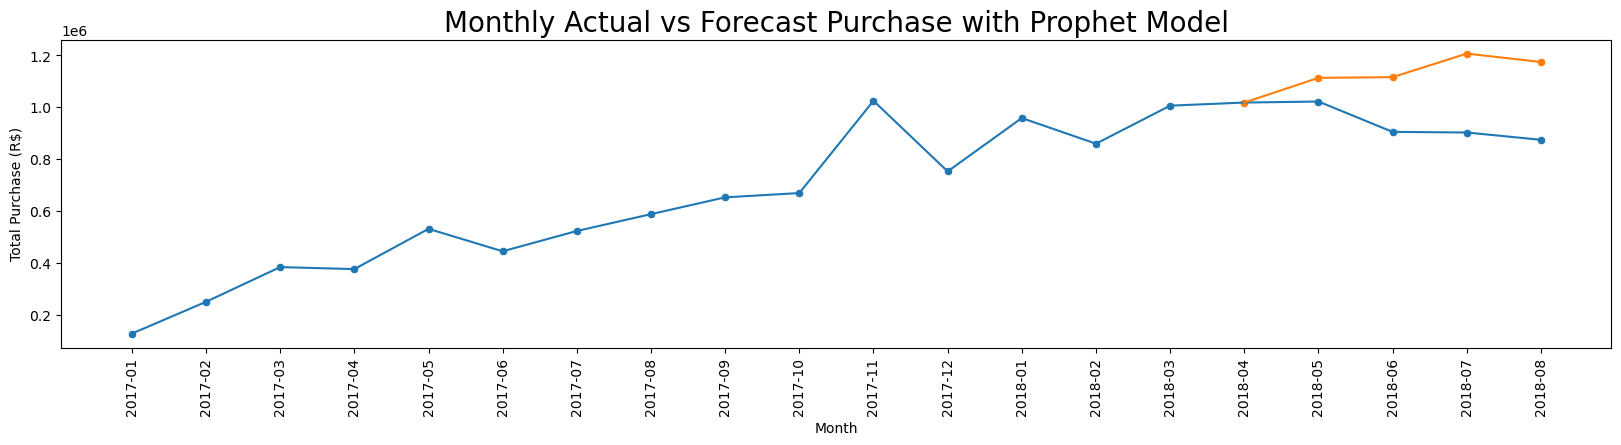

In [238]:
# Creating a graph to visualize the comparison between actual and predicted data
plt.figure(figsize = (20,4))

# Actual Purchase
df_support = df_ym.copy()
df_support['date'] = df_support['date'].astype(str)
sns.lineplot(data = df_support, x='date', y='purchase')
sns.scatterplot(data = df_support, x='date', y='purchase')

# Forecast Purchase
df_support2 = df_ym[df_ym['date']==min(data_pred['date']) - 1].copy()
df_support2.rename(columns={'purchase':'pred'},inplace=True)
df_support2 = pd.concat([df_support2,data_pred[['date','pred']]])
df_support2['date'] = df_support2['date'].astype(str)
sns.lineplot(data = df_support2, x='date', y='pred')
sns.scatterplot(data = df_support2, x='date', y='pred')

plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))
plt.title('Monthly Actual vs Forecast Purchase with Prophet Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

### ARIMA Model

The ARIMA (Autoregressive Integrated Moving Average) model is a popular time series forecasting method that uses a combination of autoregression and moving average models with differencing.

ARIMA models work by identifying patterns in the historical time series data and using those patterns to make future predictions. Specifically, ARIMA models attempt to model the underlying data-generating process by identifying and estimating the parameters of three components:

- **Autoregression (AR)** - This component uses past values of the time series to predict future values. It assumes that the value of the time series at any point in time is dependent on its own previous values.

- **Integration (I)** - This component uses differencing to remove the trend from the time series data, making it stationary. A stationary time series has constant statistical properties over time, which makes it easier to model.

- **Moving Average (MA)** - This component uses the errors from past predictions to predict future values. It assumes that the error at any point in time is dependent on the errors at previous points in time.

ARIMA models use a combination of these three components to make predictions about future values of the time series. The model is typically tuned by adjusting the values of its parameters, such as the order of differencing, the number of lagged observations, and the order of the moving average. The quality of the model's predictions can be evaluated by comparing them to the actual values in the test dataset.

**Stasionarity : Adfuller Test**

Hypotheses for the adfuller test :
- Ho: Data is not stationary
- Ha: Data is stationary

In [239]:
# Performing stationarity test using adfuller() function on the original data
pvalue = adfuller(y_train)[1]
print(pvalue)

alpha = 0.05
if pvalue <= alpha:
    print('Reject null hypothesis, The data is stationary')
else:
    print('Failed to reject null hypothesis, The data is not stationary')

0.05793290330414034
Failed to reject null hypothesis, The data is not stationary


In [240]:
# Performing stationarity test using adfuller() function on the data that has been differenced once
pvalue_diff1 = adfuller(y_train.diff().dropna())[1]
print(pvalue_diff1)

alpha = 0.05
if pvalue_diff1 <= alpha:
    print('Reject null hypothesis, The data is stationary')
else:
    print('Failed to reject null hypothesis, The data is not stationary')

2.512593281225657e-15
Reject null hypothesis, The data is stationary


Interpretation :
- The original data is not stationary
- The data becomes stationary after being differenced once.

**ACF-PACF**

ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) graphs are two types of graphs used in time series analysis to help understand the relationship between values in a time series. Both graphs can help identify patterns in the time series and determine a suitable model to model the data.

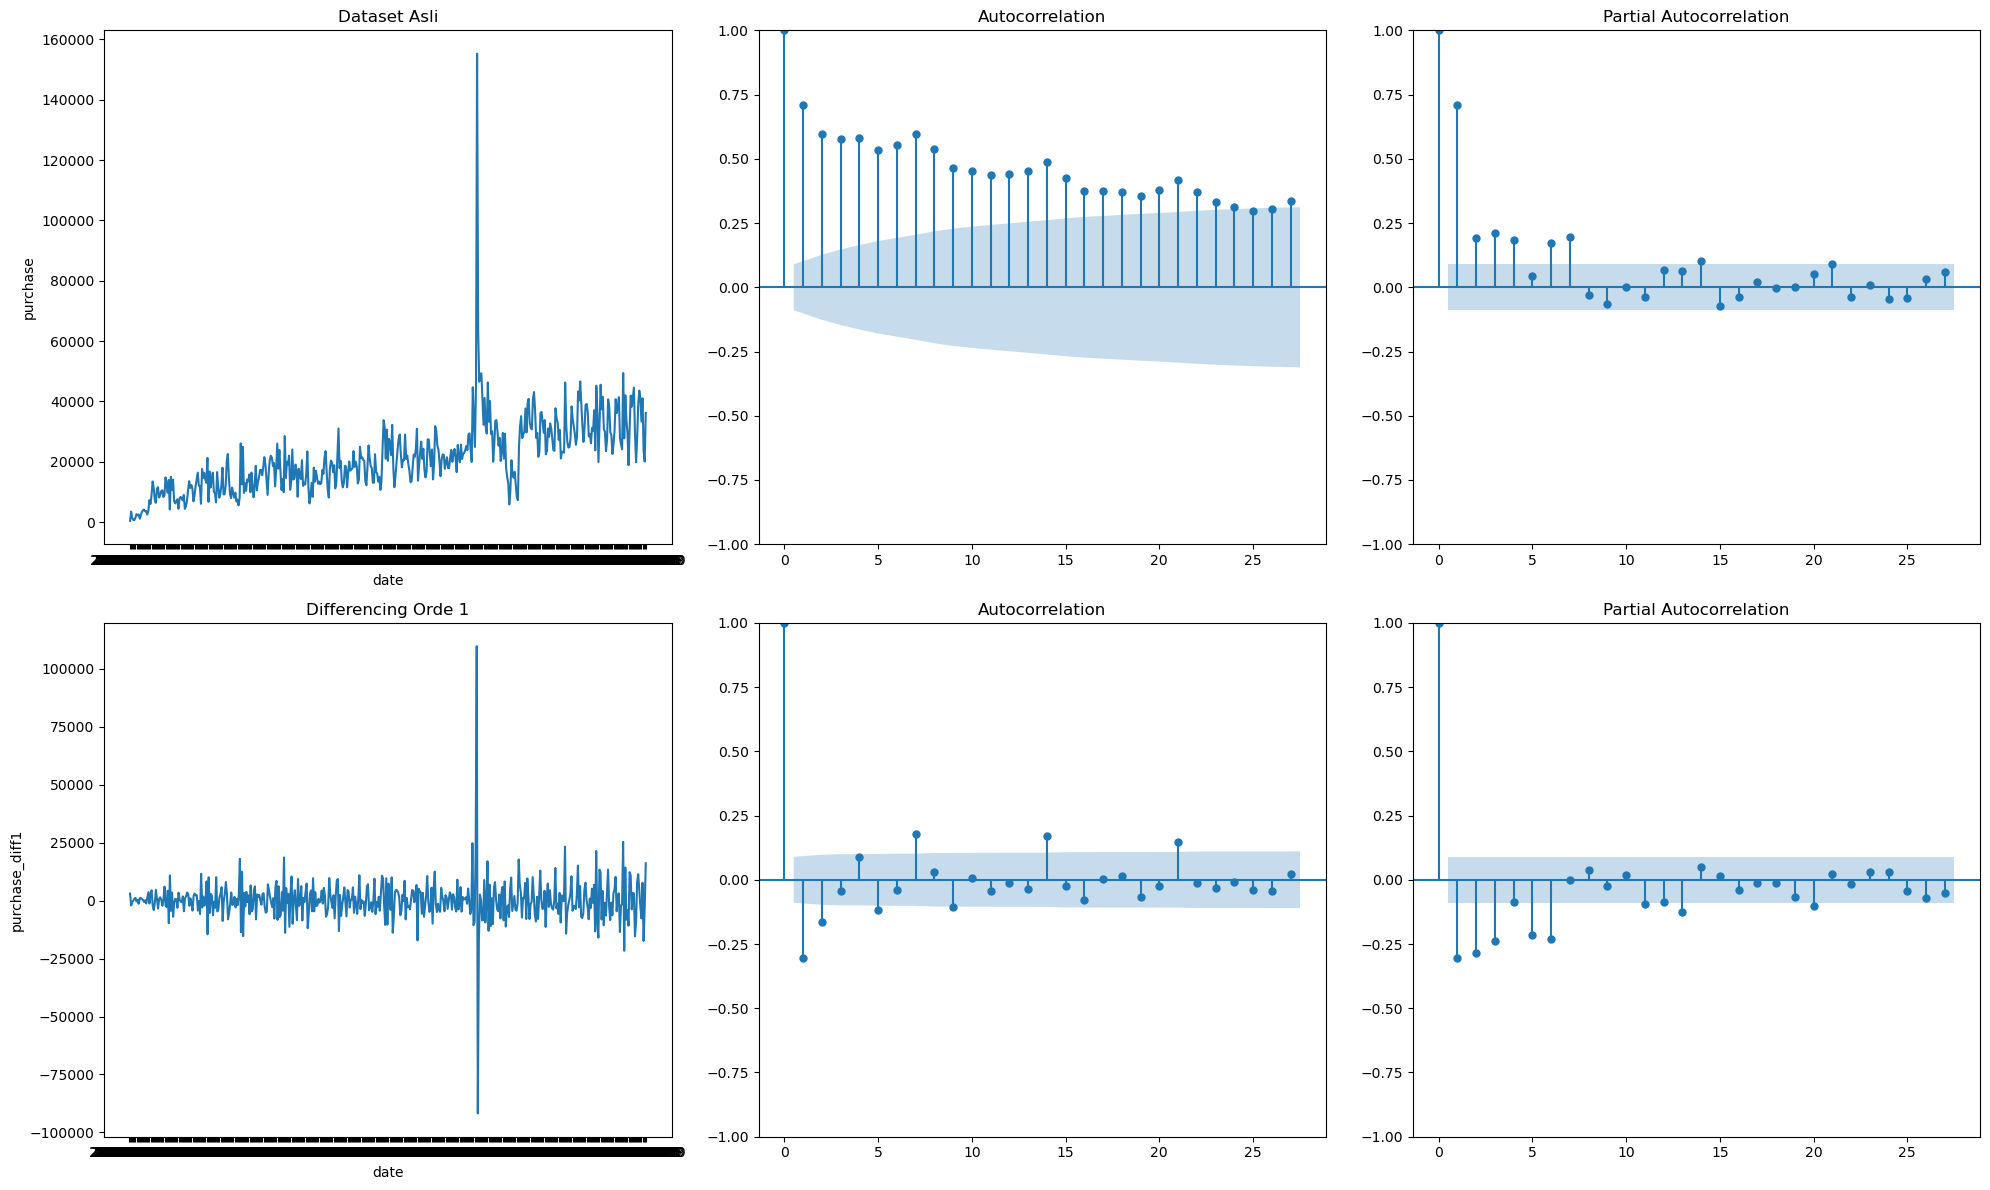

In [241]:
# Creating ACF dan PACF graphs
# Preparing data for creating graphs
data_train['purchase_diff1'] = data_train['purchase'].diff()
data_train_temporarily = data_train.copy()
data_train_temporarily['date'] = data_train_temporarily['date'].astype(str)

fig, axes = plt.subplots(2, 3, figsize=(20,12))

# Original Series
sns.lineplot(data=data_train_temporarily, x='date', y='purchase', ax= axes[0, 0])
axes[0,0].set_title('Dataset Asli')
plot_acf(data_train['purchase'], ax=axes[0, 1])
plot_pacf(data_train['purchase'], ax=axes[0, 2])

# 1st Differencing
sns.lineplot(data=data_train_temporarily, x='date', y='purchase_diff1', ax= axes[1, 0])
axes[1,0].set_title('Differencing Orde 1')
plot_acf(data_train['purchase_diff1'].dropna(), ax=axes[1, 1])
plot_pacf(data_train['purchase_diff1'].dropna(), ax=axes[1, 2])

plt.tight_layout()
plt.show()

In [242]:
# Finding the best combination of p and q
# d=1 because the data is already stationary after being differenced once

list_p = list(range(0,15)) # AR
list_q = list(range(0,15)) # MA

list_pdq = []
list_mape = []

for p in list_p:
    for q in list_q:
        list_pdq.append((p,1,q))

        model_loop = ARIMA(y_train, order=(p,1,q))
        model_loop_fit = model_loop.fit()

        y_pred_daily = model_loop_fit.forecast(len(y_test))
        y_pred_daily = y_pred_daily.values

        data_test['pred'] = y_pred_daily
        df_pred_monthly = data_test.groupby(by='month').sum()[['purchase', 'pred']].reset_index()

        mean_absolute_percentage_error=metrics.mean_absolute_percentage_error(df_pred_monthly['purchase'], df_pred_monthly['pred']) 
        mape_score = round(mean_absolute_percentage_error,4)

        list_mape.append(mape_score)

In [243]:
# Creating a dataframe of pdq combinations and MAPE values by sorting from the best (smallest) MAPE value
df_temp = pd.DataFrame({'p,d,q': list_pdq, 'mape':list_mape}).sort_values('mape')
df_temp

,"p,d,q",mape
156,"(10, 1, 6)",0.0268
30,"(2, 1, 0)",0.0322
45,"(3, 1, 0)",0.0423
60,"(4, 1, 0)",0.0434
216,"(14, 1, 6)",0.0459
...,...,...
55,"(3, 1, 10)",0.1002
42,"(2, 1, 12)",0.1015
154,"(10, 1, 4)",0.1475
0,"(0, 1, 0)",0.1849


In [244]:
df_pred_monthly

,month,purchase,pred
0,5,1021997.47,1.009554e+06
1,6,904962.20,9.742425e+05
2,7,902543.59,1.020805e+06
3,8,874349.63,9.504266e+05


In [245]:
# Converting the values of the 'month' column to have the year-month format
df_pred_monthly['month'] = ['2018-05', '2018-06', '2018-07', '2018-08']
df_pred_monthly

,month,purchase,pred
0,2018-05,1021997.47,1.009554e+06
1,2018-06,904962.20,9.742425e+05
2,2018-07,902543.59,1.020805e+06
3,2018-08,874349.63,9.504266e+05


Based on the results of determining the ARIMA model, it was found that the best p,d,q combination is ARIMA (10,1,6) with a MAPE value of 0.0268. Therefore, we will use the ARIMA model with the lowest MAPE, which is `ARIMA (10,1,6)`.

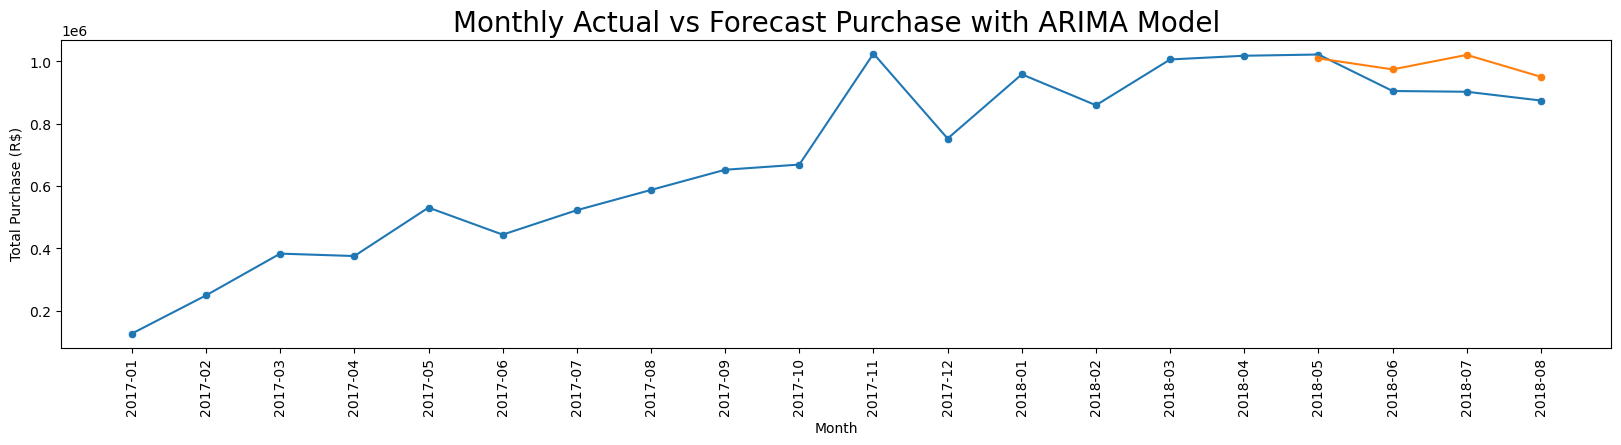

In [246]:
# Creating a graph to see the comparison between actual data and forecast data.
plt.figure(figsize = (20,4))

# Actual Purchase
df_original_series = df_ym.copy()
df_original_series['date'] = df_original_series['date'].astype(str)
sns.lineplot(data = df_original_series, x='date', y='purchase')
sns.scatterplot(data = df_original_series, x='date', y='purchase')

# Forecast Purchase
sns.lineplot(data = df_pred_monthly, x='month', y='pred')
sns.scatterplot(data = df_pred_monthly, x='month', y='pred')

plt.xticks(rotation = 90)
plt.title('Monthly Actual vs Forecast Purchase with ARIMA Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

### Enet Regression Model

Elastic Net Regression is a linear regression model that combines the L1 and L2 regularization methods to handle the limitations of each method. L1 regularization (Lasso) is used for feature selection, which shrinks the coefficients of less important variables to zero, while L2 regularization (Ridge) is used for dealing with multicollinearity and overfitting by shrinking the coefficients of highly correlated variables.

The elastic net model introduces a new hyperparameter, alpha, to balance the effects of L1 and L2 regularization. When alpha is set to 1, it is equivalent to Lasso regression, and when alpha is set to 0, it is equivalent to Ridge regression. When alpha is between 0 and 1, the model combines the effects of both regularization methods.

The elastic net model minimizes the sum of the squared residuals between the predicted values and the actual values of the dependent variable, while also adding the sum of the absolute values of the coefficients multiplied by the alpha parameter times the L1 regularization term and the sum of the squares of the coefficients multiplied by 1 minus the alpha parameter times the L2 regularization term. The goal is to find the set of coefficients that minimizes this objective function.

In summary, the elastic net model provides a compromise between Lasso and Ridge regression and can handle datasets with many features and highly correlated variables. It is commonly used in machine learning for feature selection and prediction tasks.

**FORMULA**

**Ridge :**

Mean Squared Error + Lambda*sum((slope)**2)
$$
\text{minimize } \sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}x_{ij}\beta_j)^2 + \lambda\sum_{j=1}^{p}\beta_j^2
$$

**Lasso :**

Mean Squared Error + Lambda*sum(abs(slope))
$$
\text{minimize } \sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}x_{ij}\beta_j)^2 + \lambda\sum_{j=1}^{p}|\beta_j|
$$

**Elastic Net :**

Mean Squared Error + Lambda*sum((slope)**2) + Lambda*sum(abs(slope))
$$
\text{minimize } \sum_{i=1}^{n}(y_i-\beta_0-\sum_{j=1}^{p}x_{ij}\beta_j)^2 + \lambda_1\sum_{j=1}^{p}|\beta_j|+\lambda_2\sum_{j=1}^{p}\beta_j^2
$$

where:
- $\beta_j$ represents the coefficients of the model for the $j$-th predictor variable
- $x_{ij}$ is the value of the $i$-th observation of the $j$-th predictor variable
- $y_i$ is the value of the response variable for the $i$-th observation
- $n$ is the number of observations
- $p$ is the number of predictor variables
- $\lambda$ is the regularization parameter that controls the amount of shrinkage applied to the coefficients in Ridge Regression
- $\lambda$ is the regularization parameter that controls the amount of shrinkage applied to the coefficients in Lasso Regression
- $\lambda_1$ and $\lambda_2$ are the regularization parameters that control the amount of shrinkage applied to the coefficients in Elastic Net Regression. $\lambda_1$ controls the amount of L1 (Lasso) regularization and $\lambda_2$ controls the amount of L2 (Ridge) regularization.

Choose the model, scaler, and k-fold to be used

In [247]:
models = []
models.append(('linreg', LinearRegression()))
models.append(('ridge', Ridge()))
models.append(('lasso', Lasso()))
models.append(('enet', ElasticNet()))

scaler = StandardScaler()

# We tried looping n_splits with [3,4,5,6] and 4 has the smallest average error
tscv = TimeSeriesSplit(n_splits=4)

In [248]:
# Compare the performance of several given models
# Select the model with the smallest MAPE value as the best model for prediction on the given dataset

for name, model in models:

  pipe_model = Pipeline([
                       ('scaler',scaler),
                       ('model',model),
  ])

  cv_score = cross_val_score(
      estimator = pipe_model,
      X = X_train,
      y = y_train,
      cv = tscv,
      scoring = 'neg_mean_absolute_percentage_error',
      n_jobs = -1
  )

  print(name, cv_score.mean(),f'({cv_score.std()})')

linreg -0.33257066174554456 (0.13421346152161018)
ridge -0.3301876538117312 (0.13269416090758596)
lasso -0.33246078038656923 (0.13416373511074325)
enet -0.2718496506654624 (0.09254298244197795)


In [249]:
model_candicate = ElasticNet(random_state=10)

# Hypertuning Elastic Net
param_search = {
    'model__alpha' : [1000,100,10,1,0.1,0.01,0.001],
    'model__max_iter' : range(1000,2000,500),
    'model__l1_ratio' : np.arange(0, 1, 0.01),
    'scaler' : [None, MinMaxScaler(), StandardScaler()],
}

model_candicate.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [250]:
# Determine the best model with the optimal parameters using Grid Search
pipe_model = Pipeline([
                    ('scaler',scaler),
                    ('model', model_candicate),
])

bestsearch = GridSearchCV(
    estimator = pipe_model,
    cv = tscv,
    param_grid = param_search,
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1,
    # error_score='raise'
)

bestsearch.fit(X_train, y_train)
best_score = bestsearch.best_score_
best_parameter = bestsearch.best_params_
best_model = bestsearch.best_estimator_

print(best_score, best_parameter)

-0.2717690820556622 {'model__alpha': 1, 'model__l1_ratio': 0.46, 'model__max_iter': 1000, 'scaler': StandardScaler()}


After predicting on y_test, it turned out that the daily accuracy experienced overfitting, but the error distribution is evenly spread graphically.

After trying to group by month, the accuracy became better because predicting TIV is easier to understand on a monthly basis, and we finally chose to evaluate the model's accuracy after grouping it by month.

The graph generated by enet is much better than prophet and arima.

In [251]:
# Daily Error
best_model.fit(X_train, y_train)
y_pred_tuned = best_model.predict(X_test)
regression_results(y_test, y_pred_tuned)

MAE:  8503.1874
MAPE:  0.5932
MSE:  120657953.589
RMSE:  10984.4414


In [252]:
# Monthly Error
data_test = df_ymd[(df_ymd['date']>=date_split) & (df_ymd['date']<'2018-09')]

data_test.insert(len(data_test.columns),column='pred',value=y_pred_tuned)
df_support = data_test.groupby(by='month').sum()['pred'].reset_index()

data_pred = df_ym[(df_ym['date']>=date_split) & (df_ym['date']<'2018-09')].copy()
data_pred['pred'] = list(df_support['pred'])

enet_metrics = regression_results(data_pred['purchase'], data_pred['pred'])
enet_metrics

MAE:  54773.1019
MAPE:  0.0575
MSE:  4448500436.0361
RMSE:  66697.0797


Comparison of actual vs. predicted graphs from the last 4 months

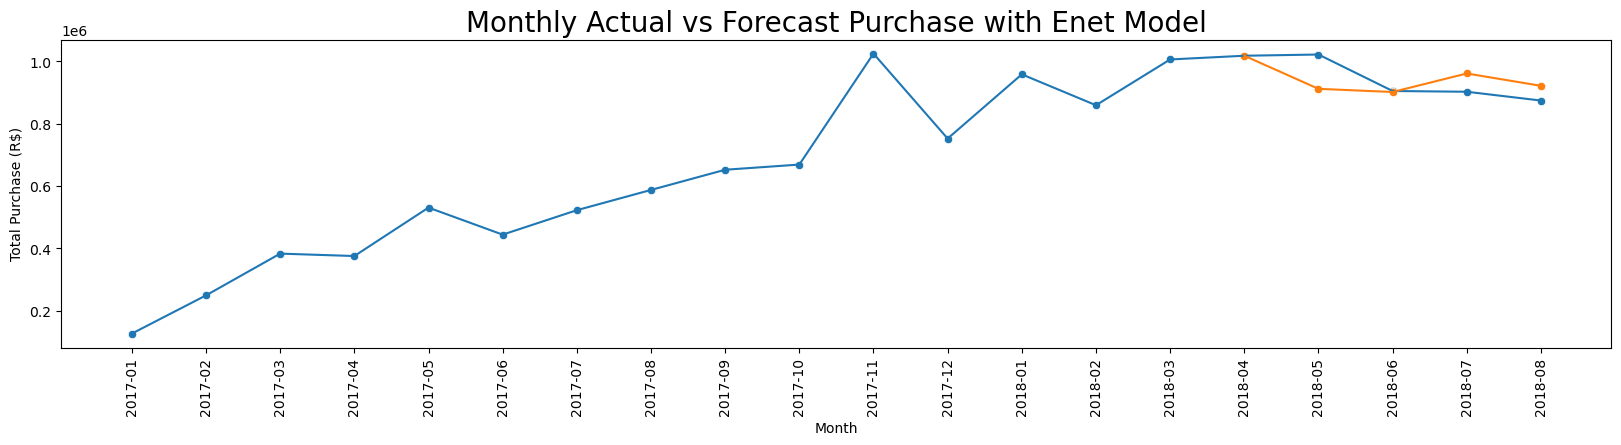

In [253]:
# Creating a graph to see the comparison between actual data and forecast data

plt.figure(figsize = (20,4))

# Actual Purchase
df_support = df_ym.copy()
df_support['date'] = df_support['date'].astype(str)
sns.lineplot(data = df_support, x='date', y='purchase')
sns.scatterplot(data = df_support, x='date', y='purchase')

# Forecast Purchase
df_support2 = df_ym[df_ym['date']==min(data_pred['date']) - 1].copy()
df_support2.rename(columns={'purchase':'pred'},inplace=True)
df_support2 = pd.concat([df_support2,data_pred[['date','pred']]])
df_support2['date'] = df_support2['date'].astype(str)
sns.lineplot(data = df_support2, x='date', y='pred')
sns.scatterplot(data = df_support2, x='date', y='pred')

plt.xticks(rotation = 90)
plt.xticks(range(len(df_support)))
plt.title('Monthly Actual vs Forecast Purchase with Enet Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

Elastic Net Regression is one type of regression technique used to model the relationship between one or more predictor variables (independent variables) with a target variable (dependent variable).

Elastic Net Regression is a combination of two types of regression, namely Ridge Regression and Lasso Regression. Ridge Regression is used to reduce overfitting, while Lasso Regression is used to perform feature selection. In Elastic Net Regression, both techniques are combined to produce a more stable model with better performance.

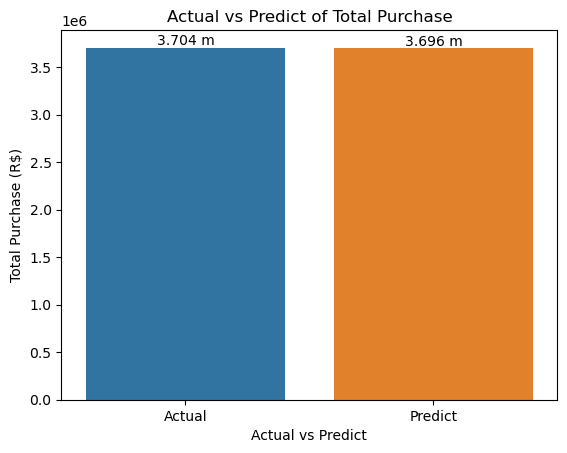

In [254]:
# Creating a chart to compare the total purchases in actual vs predicted data.
total_test_actual = data_pred['purchase'].sum()
total_test_predict = data_pred['pred'].sum()

df_support = pd.DataFrame({
    'Actual': [total_test_actual],
    'Predict': [total_test_predict],
})

ax = sns.barplot(data=df_support)

for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 3)} m'  for h in bar.datavalues])

ax.set(xlabel='Actual vs Predict', ylabel='Total Purchase (R$)',
       title='Actual vs Predict of Total Purchase')

plt.show()

In [255]:
# Actual Error dan Percentage Error
percentage_error = round(abs(total_test_actual - total_test_predict)/total_test_actual*100,2)
print(f'actual_error : {round(total_test_actual - total_test_predict,2)}')
print(f'percentage_error : {percentage_error}%')

actual_error : 7375.28
percentage_error : 0.2%


---
## **Predict to Real Case**

### Using ARIMA Model

In [256]:
# Creating an ARIMA model using the best parameters (p, d, q).
model = ARIMA(df_ymd['purchase'], order = (10, 1, 6))
model_arima = model.fit()

In [257]:
# Performing a prediction for 124 days (August 30th, 2018 - December 31st, 2018)
forecast_length = 124

forecast_result = model_arima.forecast(forecast_length)
forecast_result = forecast_result.values

forecast_result

array([ 7489.16954314,  4593.18716709,  5484.38817485,  8823.29855706,
       14971.96835512, 19541.2342366 , 19248.60815186, 17906.32402691,
       16013.53564007, 14812.10161752, 18319.60187959, 22221.09883644,
       25033.20956864, 25674.23745247, 22565.45195161, 19891.38611354,
       19450.61275766, 21082.70194318, 25277.62327667, 27682.92997564,
       27203.47261218, 24868.86056655, 21526.81956699, 20722.8405586 ,
       22941.67138676, 25979.55194017, 28637.34691252, 28144.36115948,
       25202.2008108 , 22494.88492619, 21392.97826682, 23292.05491372,
       26726.18895524, 28672.31824543, 28383.13287842, 25608.39069874,
       22570.47701461, 21881.23306136, 23586.93713208, 26712.33134518,
       28932.56531903, 28257.90676268, 25675.13317951, 22847.84965362,
       21929.557419  , 23828.61433219, 26795.03781861, 28770.85029359,
       28336.71614359, 25599.46892187, 22929.44644506, 22160.50287184,
       23841.05602264, 26853.1490381 , 28729.19653194, 28165.61942793,
      

In [258]:
# Creating the dates to be predicted
i = 0
list_date = []

while i < forecast_length:
    i += 1
    list_date.append(df_ymd['date'].iloc[-1]+i)

list_date

[Period('2018-08-30', 'D'),
 Period('2018-08-31', 'D'),
 Period('2018-09-01', 'D'),
 Period('2018-09-02', 'D'),
 Period('2018-09-03', 'D'),
 Period('2018-09-04', 'D'),
 Period('2018-09-05', 'D'),
 Period('2018-09-06', 'D'),
 Period('2018-09-07', 'D'),
 Period('2018-09-08', 'D'),
 Period('2018-09-09', 'D'),
 Period('2018-09-10', 'D'),
 Period('2018-09-11', 'D'),
 Period('2018-09-12', 'D'),
 Period('2018-09-13', 'D'),
 Period('2018-09-14', 'D'),
 Period('2018-09-15', 'D'),
 Period('2018-09-16', 'D'),
 Period('2018-09-17', 'D'),
 Period('2018-09-18', 'D'),
 Period('2018-09-19', 'D'),
 Period('2018-09-20', 'D'),
 Period('2018-09-21', 'D'),
 Period('2018-09-22', 'D'),
 Period('2018-09-23', 'D'),
 Period('2018-09-24', 'D'),
 Period('2018-09-25', 'D'),
 Period('2018-09-26', 'D'),
 Period('2018-09-27', 'D'),
 Period('2018-09-28', 'D'),
 Period('2018-09-29', 'D'),
 Period('2018-09-30', 'D'),
 Period('2018-10-01', 'D'),
 Period('2018-10-02', 'D'),
 Period('2018-10-03', 'D'),
 Period('2018-10-04'

In [259]:
# Creating a dataframe from the predicted data results
df_forecast = pd.DataFrame({
    'date': list_date,
    'purchase': forecast_result
})

df_forecast[df_forecast['date']>'2018-08-29']

,date,purchase
0,2018-08-30,7489.169543
1,2018-08-31,4593.187167
2,2018-09-01,5484.388175
3,2018-09-02,8823.298557
4,2018-09-03,14971.968355
...,...,...
119,2018-12-27,25390.179914
120,2018-12-28,23481.305798
121,2018-12-29,23109.666486
122,2018-12-30,24543.843081


In [260]:
# Combine actual data with predicted data
df_concat = pd.concat([df_ymd, df_forecast[df_forecast['date']>'2018-08-29']])[['date', 'purchase']]
df_concat

,date,purchase
0,2017-01-05,396.900000
1,2017-01-06,3460.380000
2,2017-01-07,1351.900000
3,2017-01-08,709.580000
4,2017-01-09,673.790000
...,...,...
119,2018-12-27,25390.179914
120,2018-12-28,23481.305798
121,2018-12-29,23109.666486
122,2018-12-30,24543.843081


In [261]:
# Preparing the data to be grouped by month
df_concat['date'] = df_concat['date'].astype(str)
df_concat['date'] = pd.to_datetime(df_concat['date'])

df_concat['month'] = df_concat['date'].dt.to_period('M')

In [262]:
# Grouping data by month
df_month = df_concat.groupby(by='month').sum()[['purchase']].reset_index().sort_values(by='month', ascending=True)
df_month

,month,purchase
0,2017-01,1.267208e+05
1,2017-02,2.493293e+05
2,2017-03,3.832839e+05
3,2017-04,3.755314e+05
4,2017-05,5.308884e+05
5,2017-06,4.441941e+05
6,2017-07,5.226081e+05
7,2017-08,5.875506e+05
8,2017-09,6.523536e+05
9,2017-10,6.689536e+05


In [263]:
# Splitting actual and predicted data to facilitate data visualization
df_month_final = df_month.iloc[:20]
df_forecast = df_month.iloc[19:].reset_index()

display(df_month_final, df_forecast)

,month,purchase
0,2017-01,1.267208e+05
1,2017-02,2.493293e+05
2,2017-03,3.832839e+05
3,2017-04,3.755314e+05
4,2017-05,5.308884e+05
5,2017-06,4.441941e+05
6,2017-07,5.226081e+05
7,2017-08,5.875506e+05
8,2017-09,6.523536e+05
9,2017-10,6.689536e+05


,index,month,purchase
0,19,2018-08,886431.986710
1,20,2018-09,636407.356136
2,21,2018-10,796229.753776
3,22,2018-11,762582.490614
4,23,2018-12,788349.118045


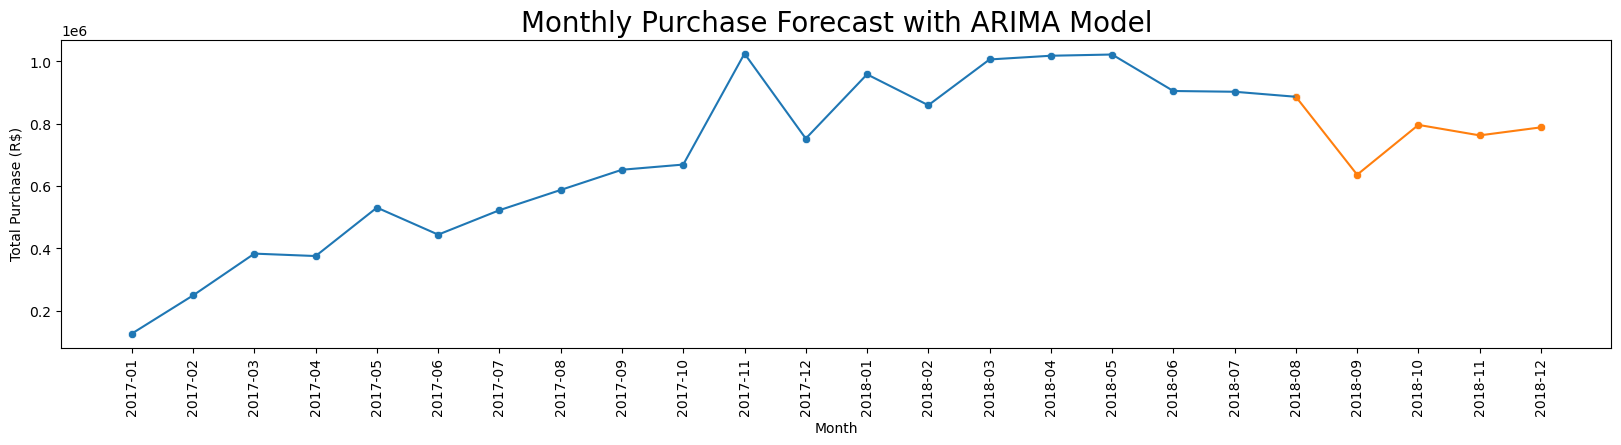

In [264]:
# Perform data visualization using a line plot.
# The predicted data is displayed in orange color.
plt.figure(figsize = (20,4))

# Actual Purchase
df_temp_actual = df_month_final.copy()
df_temp_actual['month'] = df_temp_actual['month'].astype(str)
actual = sns.lineplot(data = df_temp_actual, x='month', y='purchase')
sns.scatterplot(data = df_temp_actual, x='month', y='purchase')

# Forecast Purchase
df_temp_forecast = df_forecast.copy()
df_temp_forecast['month'] = df_temp_forecast['month'].astype(str)
forecast = sns.lineplot(data = df_temp_forecast, x='month', y='purchase')
sns.scatterplot(data = df_temp_forecast, x='month', y='purchase')

plt.xticks(rotation = 90)
plt.title('Monthly Purchase Forecast with ARIMA Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

### Using Enet Model

In [265]:
df_support = pd.DataFrame(columns=['date'])
future_months = 4
i = 0

while i < future_months :
    i += 1
    df_support.loc[len(df_support)] = max(data_pred['date'])+i

df_support['year'] = df_support['date'].dt.year
df_support['month'] = df_support['date'].dt.month
df_support['day'] = df_support['date'].dt.day

future_days = df_support['day'].sum()
year = df_support['year'][0]
month = df_support['month'][0]
day = 1

df_future_month = df_support.copy()
df_support = pd.DataFrame(columns=['date'])

for i in range(0,future_days):
    df_support.loc[len(df_support)] = datetime(year, month, day) + timedelta(days=i)

df_future = df_support.copy()

# Creating dataframe for real case
df_future['year'] = df_future['date'].dt.year
df_future['month'] = df_future['date'].dt.month
df_future['day'] = df_future['date'].dt.day
df_future['weekday'] = df_future['date'].dt.weekday

# Adding black friday feature
df_future['black_friday'] = (df_future['month']==11) & (df_future['day'].between(23,28))
df_future['black_friday'] = np.where(df_future['black_friday'] == True, 1, 0)

# Define the entire dataset as the train set and the real case dataframe as the test set
X_train = df_ymd[['year','month','day','weekday','black_friday']]
y_train = df_ymd['purchase']
X_test = df_future[['year','month','day','weekday','black_friday']]

# Fit train set and predict test set
best_model.fit(X_train, y_train)
y_pred_tuned = best_model.predict(X_test)

# Creating dataframe
df_future.insert(len(df_future.columns),column='pred',value=y_pred_tuned)
df_support = df_future.groupby(by=['year','month']).sum()['pred'].reset_index()

df_future_month.insert(len(df_future_month.columns),column='pred',value=df_support['pred'])
df_future_month

,date,year,month,day,pred
0,2018-09,2018,9,30,9.196376e+05
1,2018-10,2018,10,31,9.786085e+05
2,2018-11,2018,11,30,1.145017e+06
3,2018-12,2018,12,31,1.009539e+06


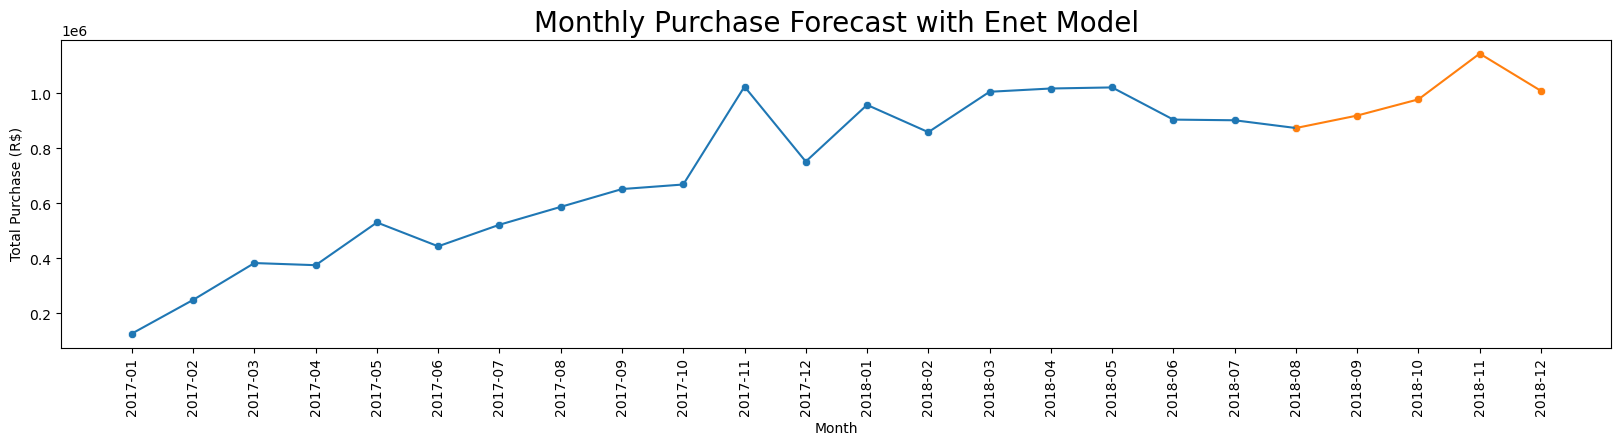

In [266]:
# Creating a graph to visualize the prediction results using Enet Model
df_support = df_ym.copy()
df_support['date'] = df_support['date'].astype(str)

df_support2 = df_future_month[['date','pred']].copy()
df_support2 = pd.concat([
    df_support.iloc[[-1]].rename(columns={'purchase':'pred'}),
    df_support2
    ])
df_support2['date'] = df_support2['date'].astype(str)

plt.figure(figsize = (20,4))

# Actual Purchase
sns.lineplot(data = df_support, x='date', y='purchase')
sns.scatterplot(data = df_support, x='date', y='purchase')

# Forecast Purchase
sns.lineplot(data = df_support2, x='date', y='pred')
sns.scatterplot(data = df_support2, x='date', y='pred')
    
plt.xticks(rotation = 90)
plt.title('Monthly Purchase Forecast with Enet Model', size= 20)
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Month')
plt.show()

In [267]:
total_pred_tiv = df_future_month['pred'].sum()
print(f'The total predicted TIV for the next {future_months} months is around {round(total_pred_tiv,2)} R$')

The total predicted TIV for the next 4 months is around 4052801.79 R$


In the end, we recommend the Enet model over ARIMA because after testing on the real case, the Enet prediction seems to be more acceptable than ARIMA. Moreover, in November, Enet predicts a surge that seems to be caused by Black Friday, like last year's November.

From these numbers, we can determine the required marketing budget. One way is to use our marketing performance benchmark from the previous period, for example:

If our performance in the previous period could achieve TIV **16 R$** with a marketing budget of **4 R$**<br>
Then if this period's **prediction** of TIV is **20 R$**, it can be achieved with a marketing budget of **5 R$**<br>

*Note: the numbers here are just examples, the marketing team may have different opinions.*

**Enet Prediction and Recommendation**

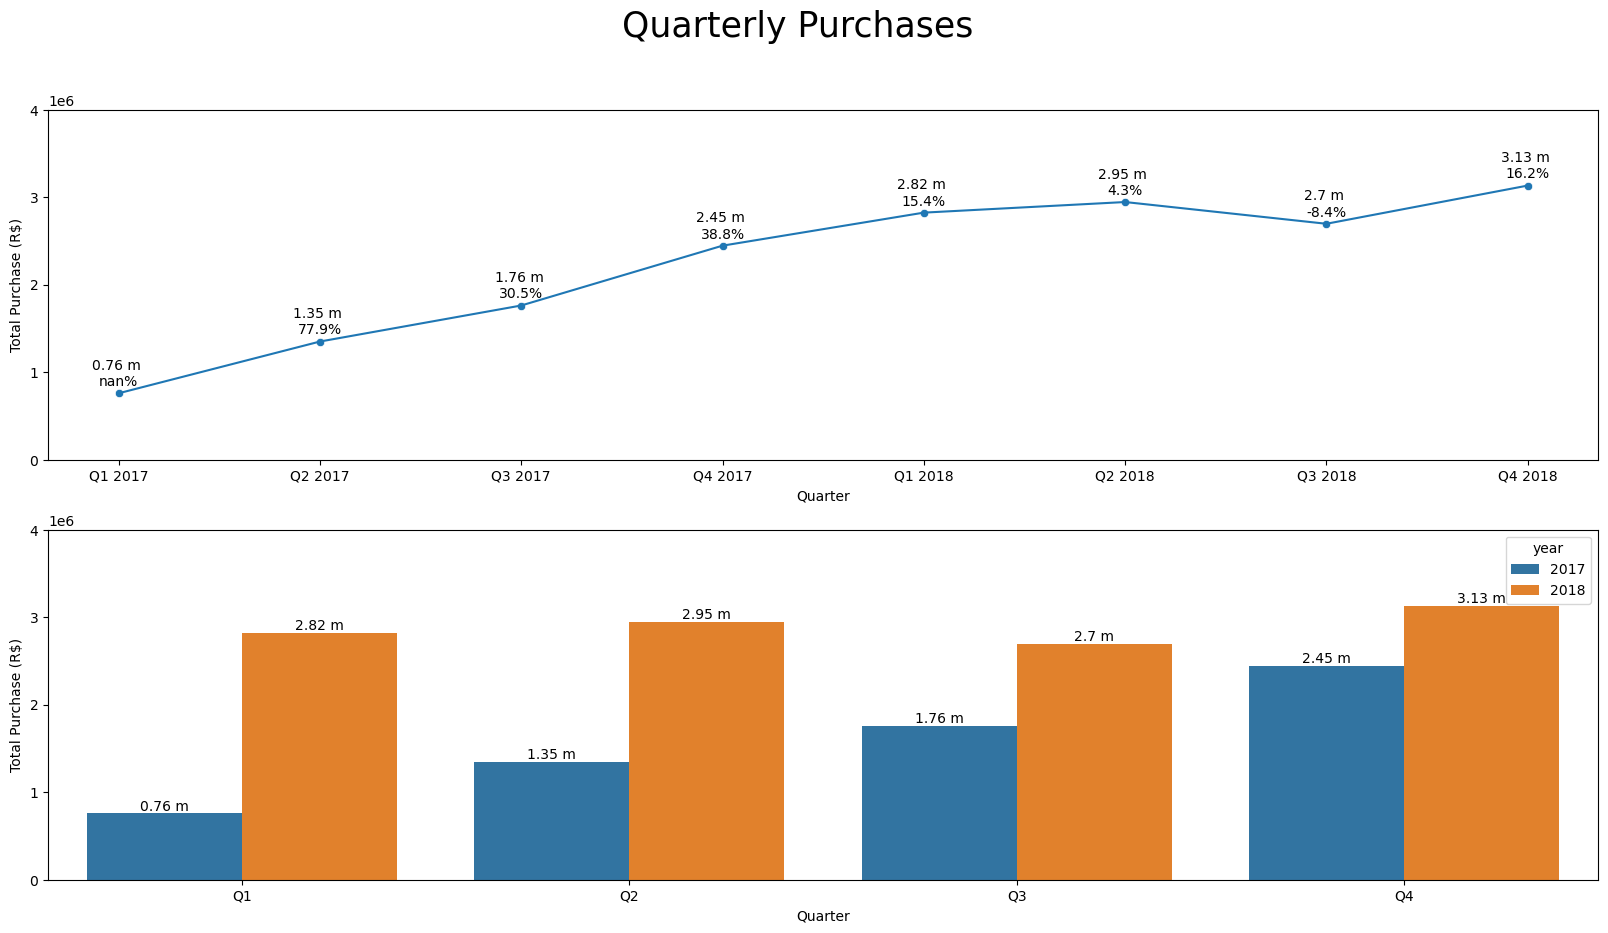

In [268]:
# Combine the original data with the predicted data into one dataframe
df_enet_future = df_future_month.copy().rename(columns={'pred':'purchase'})[['date','purchase']]
df_final = pd.concat([df_ym, df_enet_future]).reset_index()[['date','purchase']]
df_final.head()

# Preparing to make quarterly data
df_final['year'] = df_final['date'].dt.year
df_final['month'] = df_final['date'].dt.month

# Creating a quarter column by dividing the data based on quarters
df_final['quarter'] = (df_final['month'] - 1) // 3 + 1

# Creating a year_quarter column by combining the year and quarter columns
df_final['year_quarter'] = df_final['year'].astype(str) + '-Q' + df_final['quarter'].astype(str)

# Aggregating data based on year_quarter by summing up purchases
df_quarter = df_final.groupby('year_quarter')['purchase'].sum().reset_index()

# Adding a new column to the dataframe
df_quarter['pct_change'] = df_quarter['purchase'].pct_change() * 100

# Creating a line plot and bar plot
plt.figure(figsize=(20, 10))

## LINEPLOT
plt.subplot(2,1,1)
lineplot = sns.lineplot(data=df_quarter, x='year_quarter', y='purchase')
sns.scatterplot(data=df_quarter, x='year_quarter', y='purchase')
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Quarter')
labels = ['Q{} {}'.format(q, y) for y in range(df_ymd['year'].min(), df_ymd['year'].max() + 1) for q in range(1, 5)]
lineplot.set_xticklabels(labels=labels)
plt.yticks(ticks=range(0,5000000,1000000))

## Adding annotations to the line plot
for i, value in enumerate(df_quarter['purchase']):
    text = f'''{round(value/1e6, 2)} m 
{round(df_quarter["pct_change"][i], 1)}%'''
    lineplot.annotate(text, xy=(df_quarter['year_quarter'][i], value), 
                      xytext=(df_quarter['year_quarter'][i], value+50000),
                      ha='center', va='bottom')

## BARPLOT 
plt.subplot(2,1,2)
barplot = sns.barplot(data=df_final, x='quarter', y='purchase', hue='year', estimator=np.sum, errorbar=('ci',0))
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Quarter')
barplot.set_xticklabels(labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.yticks(ticks=range(0,5000000,1000000))

## Adding annotations to the bar plot
for bar in barplot.containers:
    barplot.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in bar.datavalues])


plt.suptitle('Quarterly Purchases', size=25)
plt.show()

Interpretation :
- Q4 is predicted to rebound and reach the highest TIV record 
- Marketing budgets can use the average benchmark of this year.

---
## **Model Evaluation**

**Who is suitable to use this model?**

This model is suitable for the marketing team to get an idea about the estimated Total Item Value (TIV) that can be obtained in the future. From this prediction, it is hoped that it can help the marketing team to avoid overbudgeting in determining the budget and to help develop measurable strategies and KPIs.

**Model Limitations**

As a time series model, it has several limitations, especially in terms of the features used, which are only the date and cannot use other features that are uncertain (for example, volume, in the real case we do not know how much volume will occur). Additionally, in fbprophet and arima, no date can be missed.

Furthermore, this model only learned from 20 months of data (16 for training and 4 for testing). Therefore, we chose to make daily predictions instead of monthly predictions. With monthly predictions, the model only learns from 16 rows and 2 features (year and month), while with daily predictions, it can learn from 480 rows and 4 features (year, month, day, weekday).

If we look at the daily predictions on the test set, the error tends to be large because predicting people's shopping behavior on a daily basis is naturally difficult. However, if we look at the big picture through monthly or quarterly predictions, the model is more accurate.

**Improvements that we can make**

The model uses daily predictions but for evaluation, we aggregate the data by month to measure the metrics. Therefore, the best parameters are actually intended for daily predictions, not monthly. In the future, if we want to obtain the best parameters for monthly predictions, we can create our own script using looping.

In addition, we can do feature engineering, such as labeling weekends or holidays.


---
## **Business Recommendation**

### **`How to Increase Retention and Average Basket Size (ABS)?`**

**Average Basket Size (ABS)**

The average customer makes a purchase in one checkout.

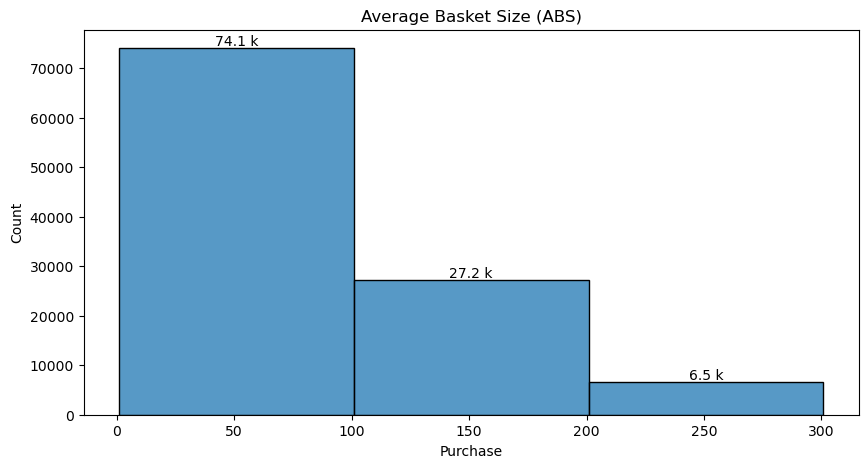

In [269]:
plt.figure(figsize = (10,5))
ax = sns.histplot(data=df_orders[df_orders['purchase']<=300],x='purchase',binwidth=100,kde=False)

# Adding annotation
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 1)} k'  for h in bar.datavalues])

# Setting axis labels and title
ax.set(xlabel='Purchase', ylabel='Count',
       title='Average Basket Size (ABS)')

plt.show()

#### **`1st RECOMMENDATION`**

Increasing Average Basket Size (ABS) and user retention by providing discount vouchers.

The Average Basket Size (ABS) of customers is 75 R$. We can increase the Average Basket Size (ABS) to 90 R$ in 2019, for example by: If a customer makes a minimum purchase of 90 R$, they will receive a discount voucher worth 10 R$.

**Benefits for Customer :**
- By adding ABS 15 R$ (from 75 R$ to 90 R$), customers can get a *discount voucher* of 10 R$. 

**Benefits for Company :**
- *Increase the ABS* from 75 R$ to 90 R$
- *Increase the retention rate*, because with the discount voucher, it can encourage customers to use our platform again when they want to shop so that the voucher they received will not be wasted.

*Note: the numbers here are just an example, the marketing team may have a different opinion.*

### **`What are The Performance and Potential of The City?`**

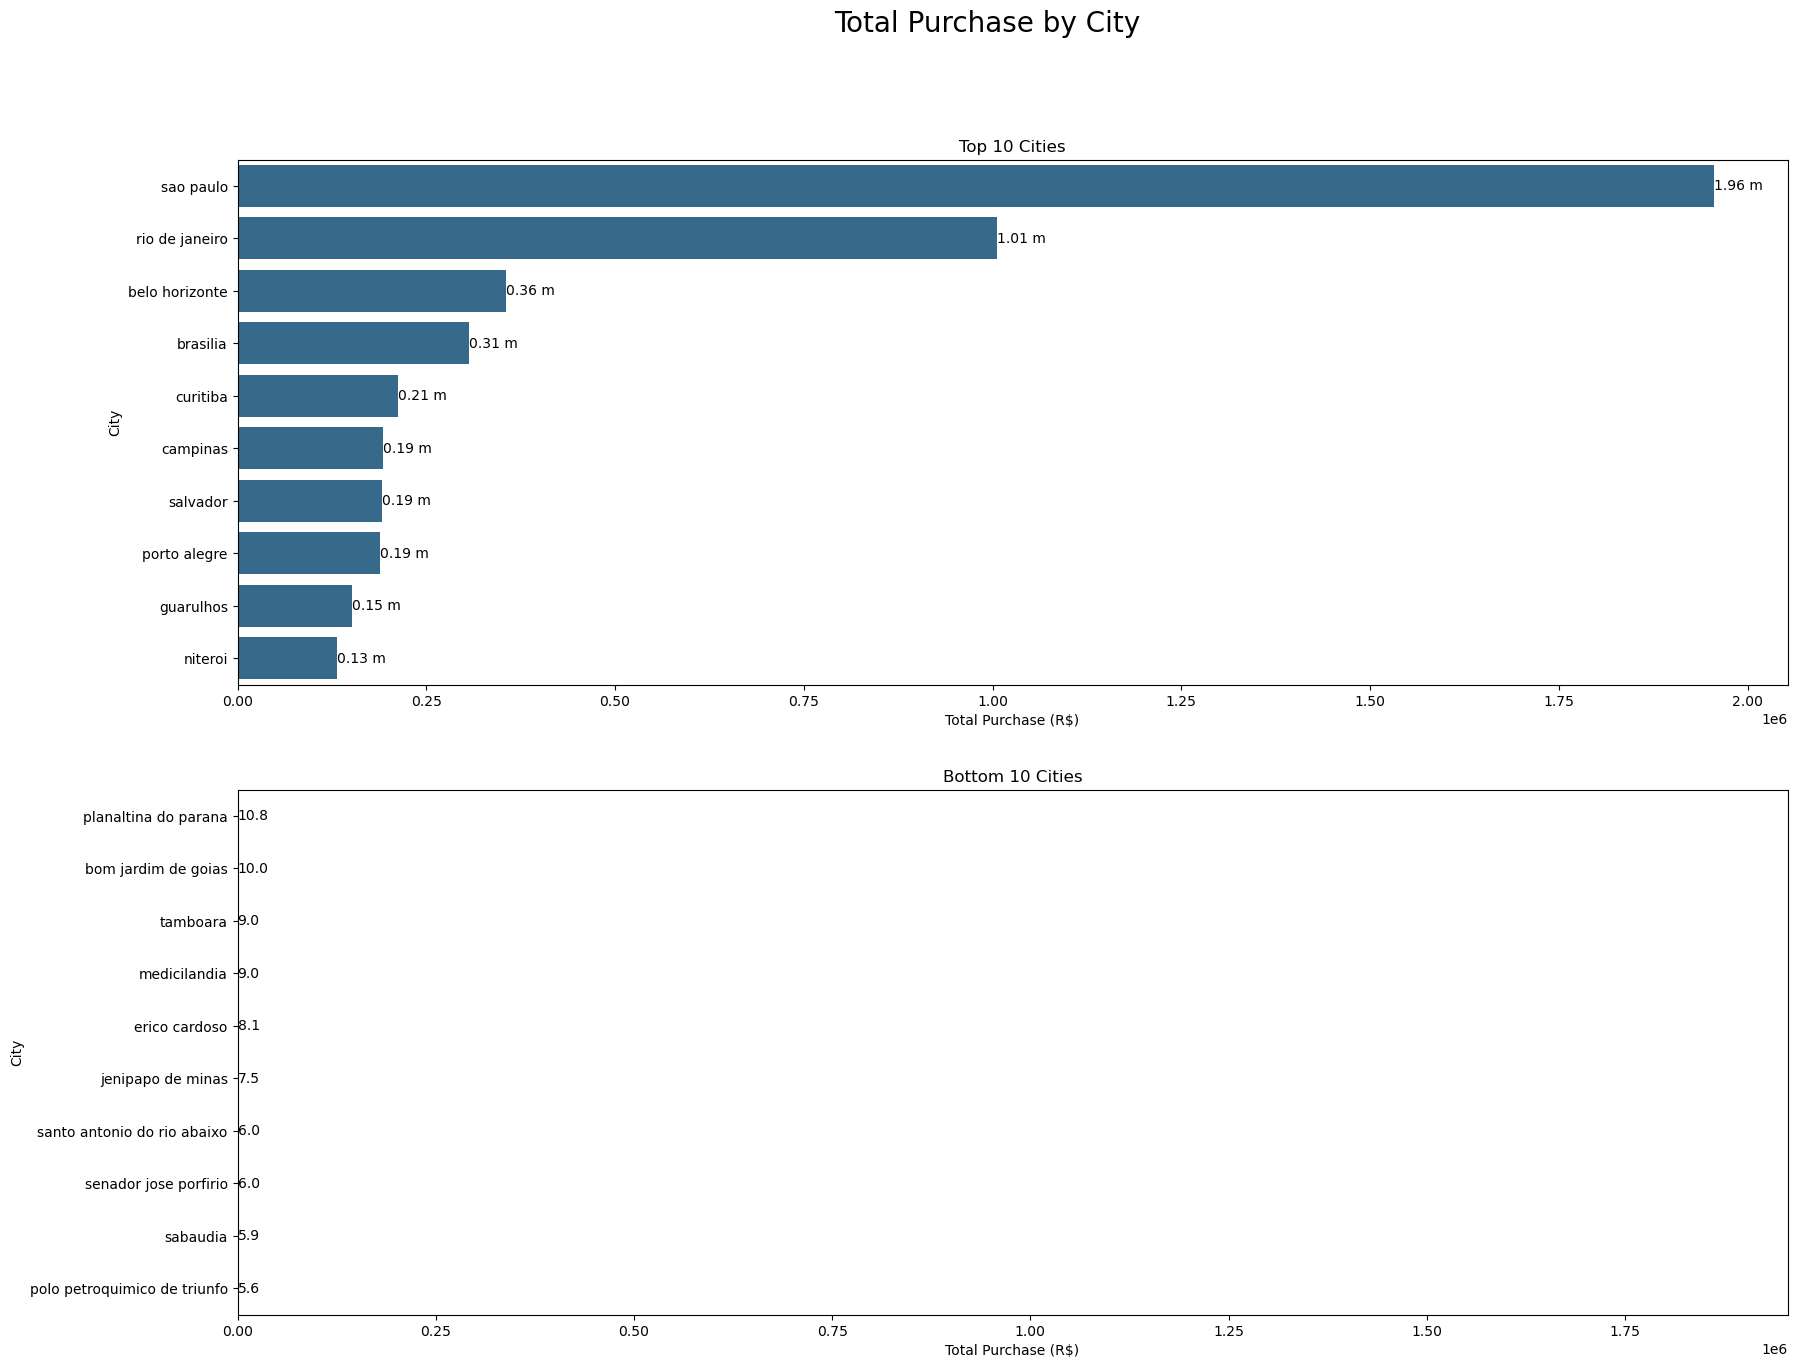

In [270]:
# Top 10 Cities 
df_city = df_orders.groupby(by='customer_city').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_city_top10 = df_city.head(10)

# Bottom 10 Cities 
df_city_bottom = df_city.tail(10)

# Creating barplot
plt.figure(figsize = (20,15))

plt.subplot(2,1,1)
top = sns.barplot(data=df_city_top10,x='purchase',y='customer_city',color='#296d98')
top.set(xlabel='Total Purchase (R$)', ylabel='City',
       title='Top 10 Cities')
# Adding annotation
for i in top.containers:
    top.bar_label(i, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in i.datavalues])

plt.subplot(2,1,2)
bottom = sns.barplot(data=df_city_bottom,x='purchase',y='customer_city',color='#296d98')
bottom.set(xlabel='Total Purchase (R$)', ylabel='City',
       title='Bottom 10 Cities')

for j in bottom.containers:
    bottom.bar_label(j, label_type='edge', labels=[round(h, 1)  for h in j.datavalues])

plt.xlim(0, max(df_city['purchase']))
plt.suptitle('Total Purchase by City', size=20)
plt.show()

In [271]:
df_support = df_orders.groupby(by='customer_city').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_support2 = df_orders.groupby(by='customer_city').count()[['purchase']].reset_index().sort_values(by='purchase',ascending=False).rename(columns={'purchase':'total_customer'})

df_support['percentage'] = df_support['purchase']/df_support['purchase'].sum()*100
df_support['percent_cumsum'] = df_support['percentage'].cumsum()

df_top_pop_city = pd.DataFrame({
    'customer_city': ['sao paulo', 'rio de janeiro', 'brasilia', 'salvador', 'fortaleza', 'belo horizonte', 'manaus'],
    'population_est_2021': [12396372,6775561,3094325,2900319,2703391,2530701,2255903]
})

df_top_pop_city = df_support.merge(df_top_pop_city,on='customer_city').merge(df_support2,on='customer_city')

print(f'Number of Cities : {len(df_support)}\nThe top 2 cities accounted for 21% of total purchase')
df_top_pop_city['acq_rate'] = df_top_pop_city['total_customer']/df_top_pop_city['population_est_2021']*100
df_top_pop_city.head(3)

Number of Cities : 4091
The top 2 cities accounted for 21% of total purchase


,customer_city,purchase,percentage,percent_cumsum,population_est_2021,total_customer,acq_rate
0,sao paulo,1955055.20,14.101095,14.101095,12396372,18097,0.145986
1,rio de janeiro,1005338.38,7.251137,21.352232,6775561,7989,0.117909
2,belo horizonte,355349.28,2.563004,23.915236,2530701,3163,0.124985


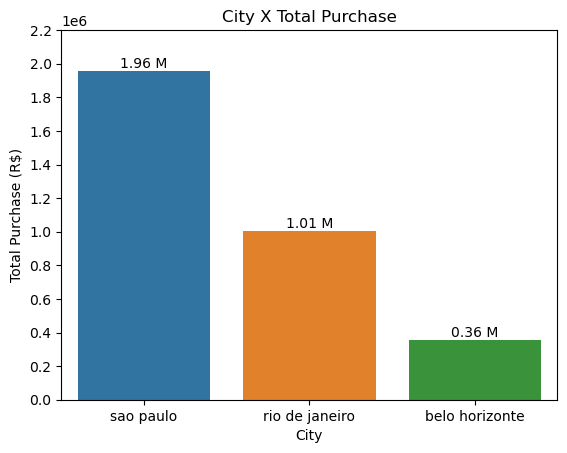

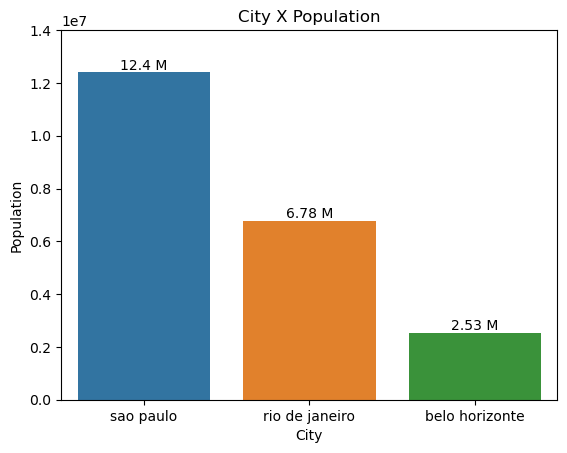

In [272]:
a= sns.barplot(data=df_top_pop_city.head(3),x='customer_city',y='purchase')
for bar in a.containers:
    a.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} M'  for h in bar.datavalues])
plt.ylabel('Total Purchase (R$)')
plt.yticks(ticks=range(0,2400000,200000))
plt.xlabel('City')
plt.title('City X Total Purchase')

plt.show()

a= sns.barplot(data=df_top_pop_city.head(3),x='customer_city',y='population_est_2021')
for bar in a.containers:
    a.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} M'  for h in bar.datavalues])
plt.ylabel('Population')
plt.yticks(ticks=range(0,16000000,2000000))
plt.xlabel('City')
plt.title('City X Population')

plt.show()

It's possible that with organic marketing, TIV in the top 2 cities remains good. It's also possible that other cities have less competition, thus making marketing budget cheaper.

The top 3-7 cities with the largest population have almost the same amount
Brasilia, Salvador, Fortaleza, Manaus, and Belo Horizonte (ranked 3rd) have similar population sizes,
it is possible that the sales potential in these 5 cities is the same.


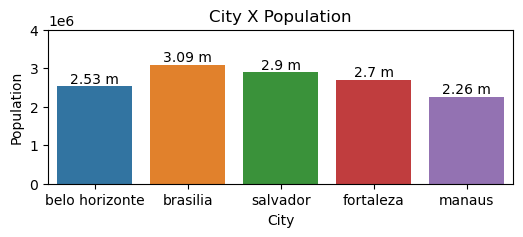

Although the population is similar, it is inversely related to User Acquisition and TIV.


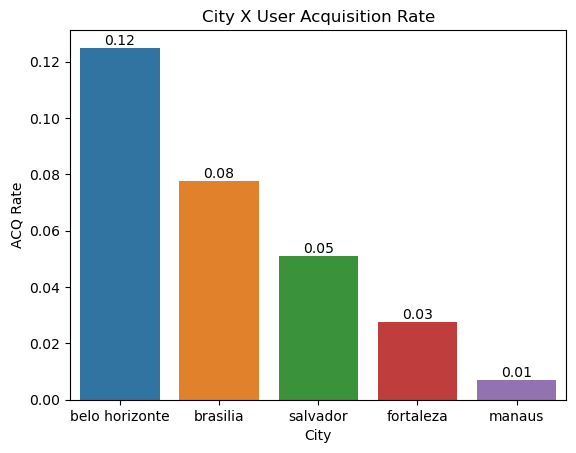

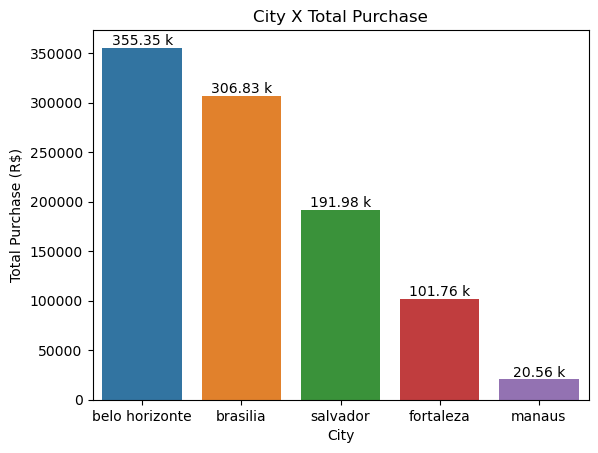

In [273]:
plt.figure(figsize = (6,2))

print('The top 3-7 cities with the largest population have almost the same amount')
print('''Brasilia, Salvador, Fortaleza, Manaus, and Belo Horizonte (ranked 3rd) have similar population sizes,
it is possible that the sales potential in these 5 cities is the same.''')
a= sns.barplot(data=df_top_pop_city[2:],x='customer_city',y='population_est_2021')
for bar in a.containers:
    a.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in bar.datavalues])
plt.ylabel('Population')
plt.yticks(ticks=range(0,5000000,1000000))
plt.xlabel('City')
plt.title('City X Population')

plt.show()

print('Although the population is similar, it is inversely related to User Acquisition and TIV.')
b= sns.barplot(data=df_top_pop_city[2:],x='customer_city',y='acq_rate')
for bar in b.containers:
    b.bar_label(bar, label_type='edge', labels=[round(h,2)  for h in bar.datavalues])
plt.ylabel('ACQ Rate')
plt.xlabel('City')
plt.title('City X User Acquisition Rate')
plt.show()

c = sns.barplot(data=df_top_pop_city[2:],x='customer_city',y='purchase')
for bar in c.containers:
    c.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 2)} k'  for h in bar.datavalues])
plt.ylabel('Total Purchase (R$)')
plt.xlabel('City')
plt.title('City X Total Purchase')
plt.show()


#### **`2nd RECOMMENDATION`**

Improving user acquisition in cities that have potential (high population but low user acquisition rate).

We can reduce promotions in the top 2 cities and rely more on brand marketing, CRM, and organic methods without reducing the Total Item Value (TIV). Then, promotions can be shifted to other cities that have high growth potential, such as :

- Brasilia
- Salvador
- Fortaleza
- Manaus

Compared to Belo Horizonte, the cities above have a similar population size, but the user acquisition rate is still lower, resulting in a lower total purchase than Belo Horizonte.

We can increase user acquisition in these cities through several steps such as :

- Trying offline marketing (banners, billboards)
- Creating marketing content with local wisdom
- Providing special promotions for new users from these cities.

### **`What are The Potential and Obstacles of The Best-Selling Product?`**

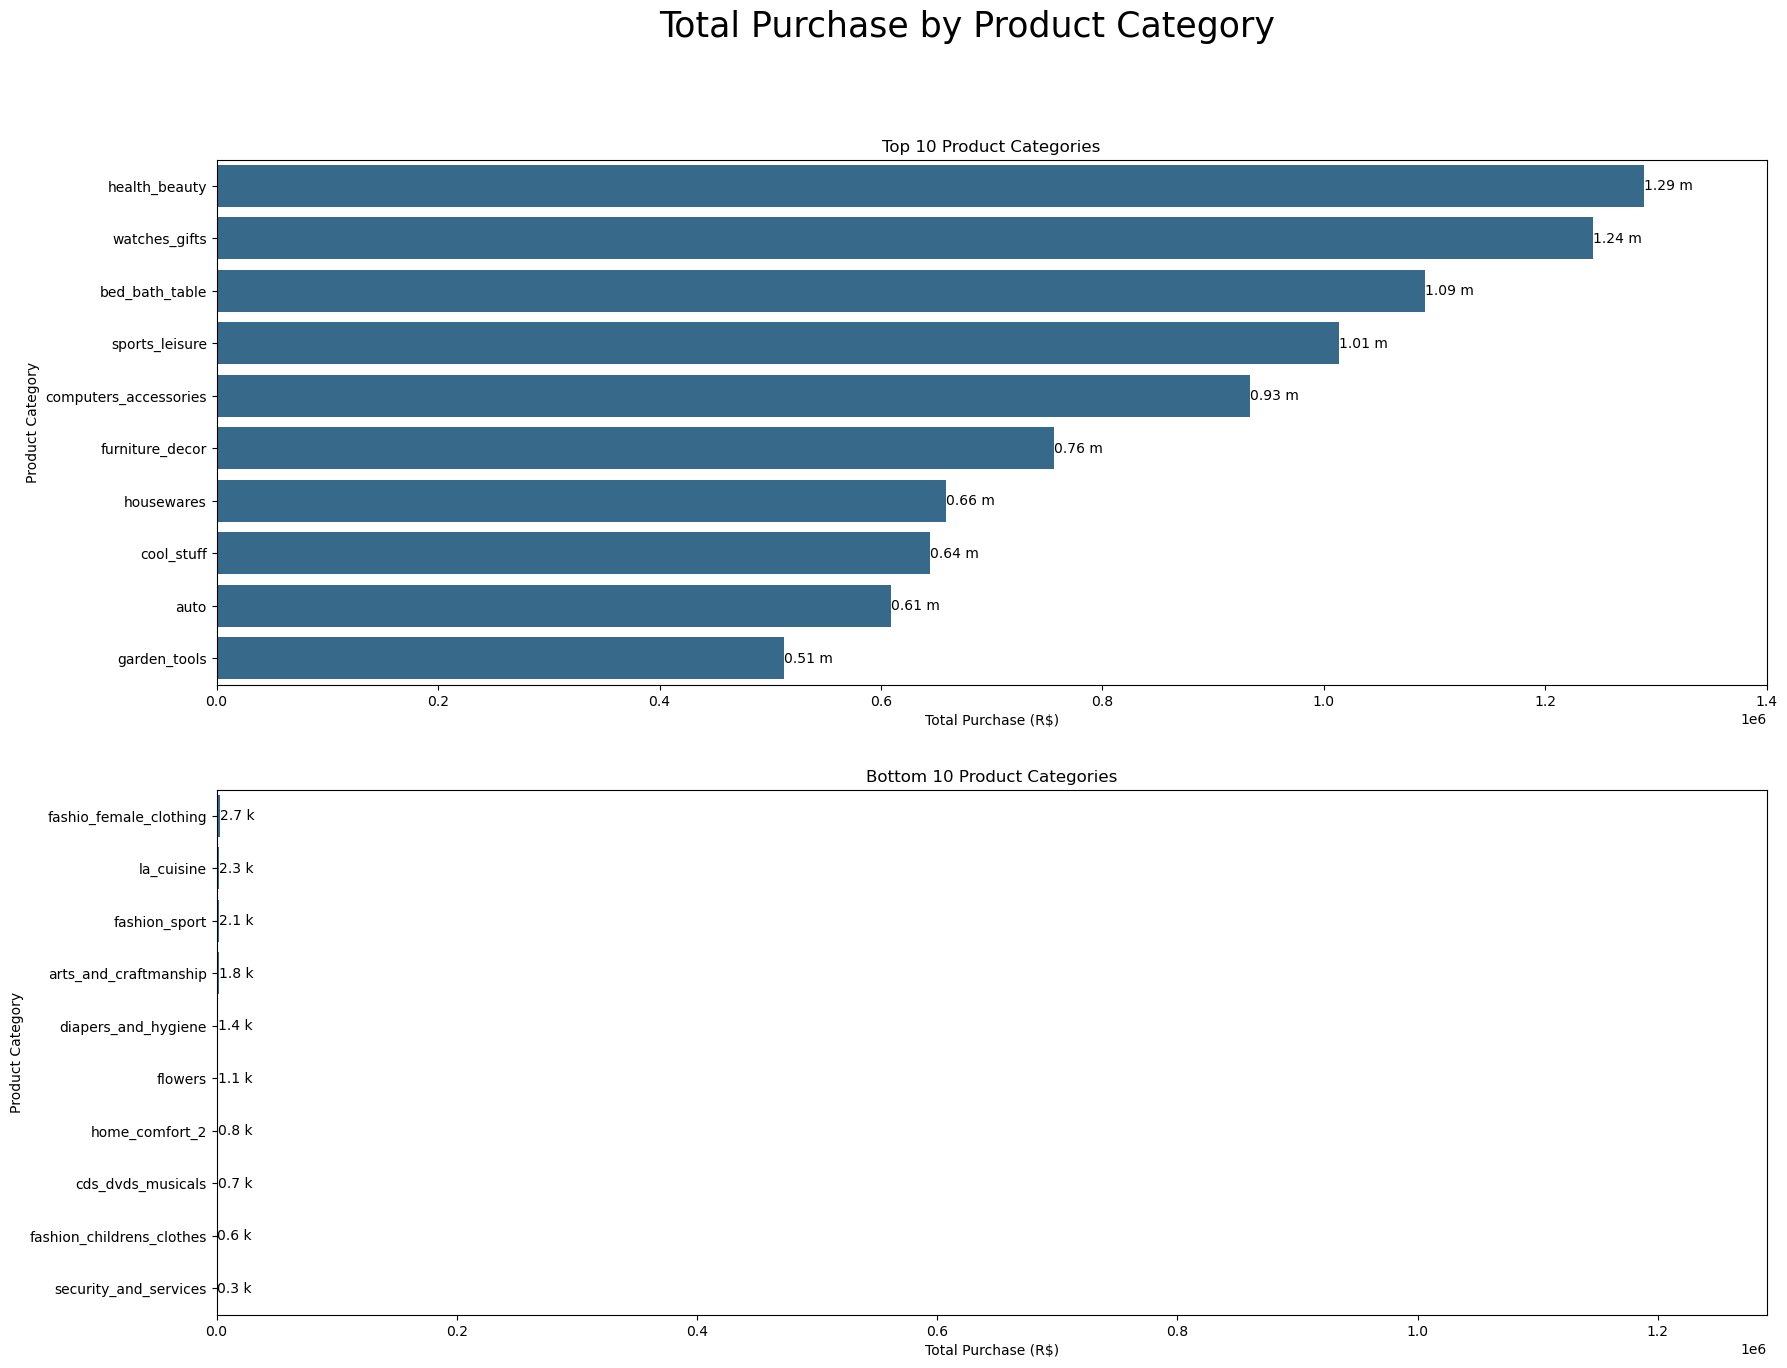

In [274]:
# Top 10 Product Categories
df_product_cat = df_orders.groupby(by='product_category_name_english').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_product_cat_top10 = df_product_cat.head(10)

# Bottom 10 Product Categories
df_product_cat_bottom = df_product_cat.tail(10)
df_product_cat_bottom

# Creating barplot
plt.figure(figsize = (20,15))

plt.subplot(2,1,1)
top = sns.barplot(data=df_product_cat_top10, x='purchase', y='product_category_name_english', color='#296d98')
top.set(xlabel='Total Purchase (R$)', ylabel='Product Category',
       title='Top 10 Product Categories')
plt.xlim(0, df_product_cat_top10['purchase'].max() + 1000) 
plt.xticks(ticks=range(0,1600000,200000))

# Adding annotation
for i in top.containers:
    top.bar_label(i, label_type='edge', labels=[f'{round(h/1e6, 2)} m'  for h in i.datavalues])

plt.subplot(2,1,2)
bottom = sns.barplot(data=df_product_cat_bottom, x='purchase', y='product_category_name_english', color='#296d98')
bottom.set(xlabel='Total Purchase (R$)', ylabel='Product Category',
       title='Bottom 10 Product Categories')
plt.xlim(0, df_product_cat_top10['purchase'].max() + 1000) 

for j in bottom.containers:
    bottom.bar_label(j, label_type='edge', labels=[f'{round(h/1e3, 1)} k'  for h in j.datavalues])

plt.suptitle('Total Purchase by Product Category', size=25)
plt.show()

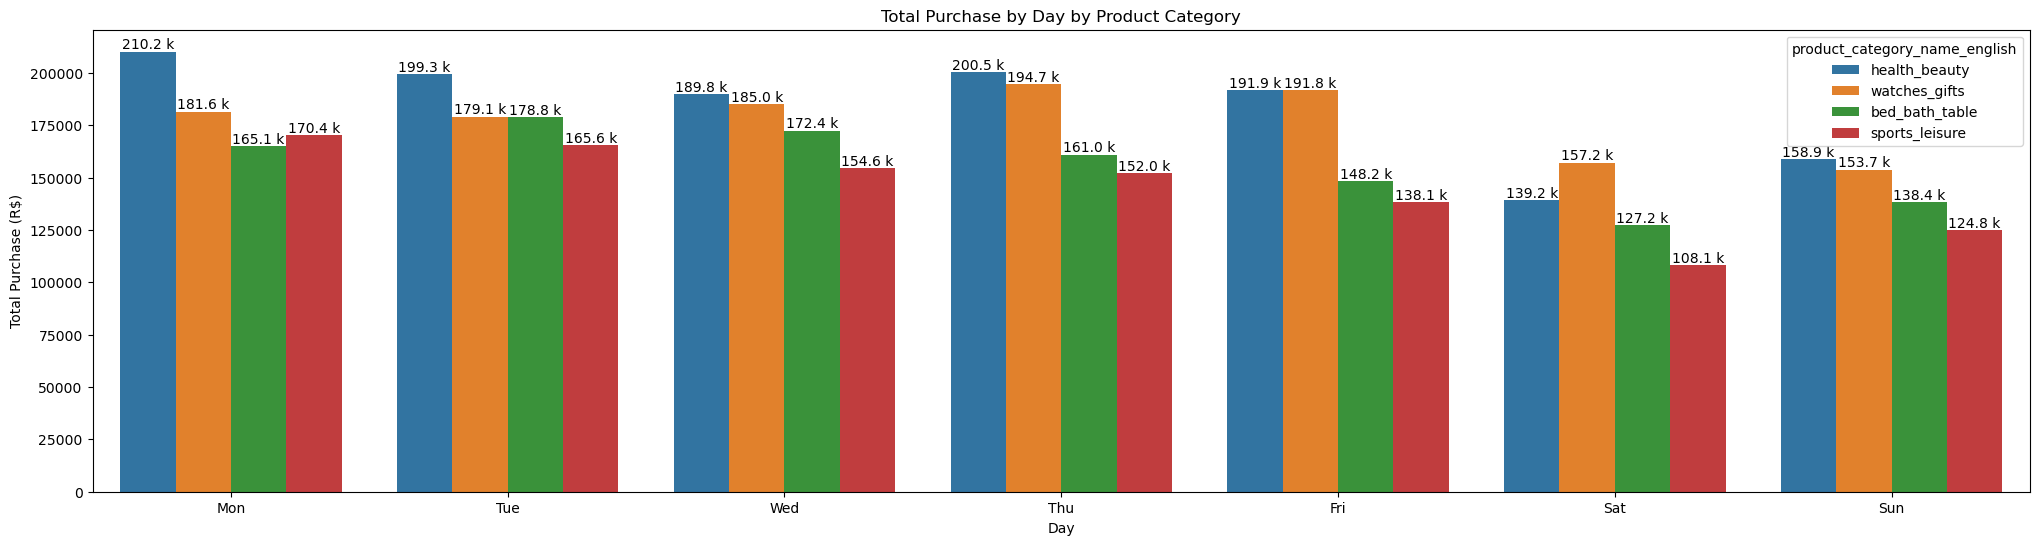

In [275]:
# Preparing the data to create a graph
top_list = list(df_product_cat_top10['product_category_name_english'].head(4))

df_support = df_orders.copy()
df_support['weekday'] = df_support['date'].dt.weekday
df_support = df_support.groupby(by=['product_category_name_english','weekday']).sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)

df_support = df_support[df_support['product_category_name_english'].isin(top_list)]

# Creating a graph of total purchases by day for each top product category
plt.figure(figsize = (25,6))
ax = sns.barplot(data=df_support,x='weekday',y='purchase',ci=True,hue='product_category_name_english')
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 1)} k'  for h in bar.datavalues])
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Day')
plt.title('Total Purchase by Day by Product Category')

plt.show()

#### **`3rd RECOMMENDATION`**

It does seem that there are certain product categories that sell better than others. To support the sales of these categories, we can try to create special campaigns based on specific days, such as:

- Mondays for Beauty Day (Only 1 day)
- Thursdays and Fridays for Watches Day
- Tuesdays and Wednesdays for Bed-Bath Day
- Saturdays and Sundays for Sport Day

In addition, we also need to ensure the availability of supply for these products. If there is a purchase but suddenly no stock is available, besides being able to cancel the order, we may receive a bad review from a disappointed customer even though it is not our fault.

The easiest way to address this is by providing notifications to the seller to ensure the availability of the stock, as these product categories are frequently purchased.

### **`How to Improve Service in line with The Increasing Number of Transactions?`**

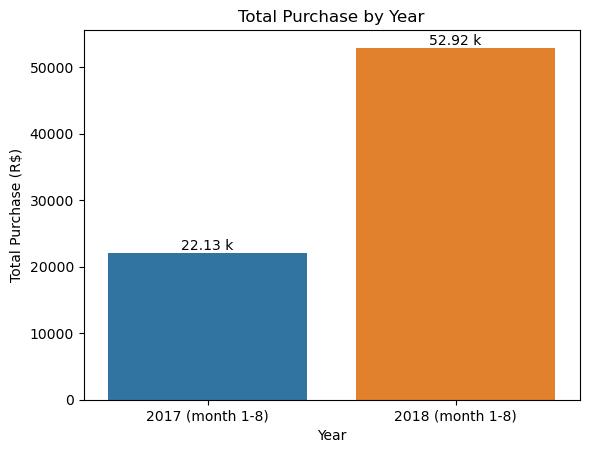

In [276]:
# Preparing the data to create a graph
df_support = df_orders[['order_id','month']].drop_duplicates()
volume_2017 = df_support[(df_support['month']>='2017-01')&(df_support['month']<='2017-08')]
volume_2018 = df_support[(df_support['month']>='2018-01')&(df_support['month']<='2018-08')]

df_support = pd.DataFrame({
    'year': ['2017 (month 1-8)','2018 (month 1-8)'],
    'volume': [len(volume_2017),len(volume_2018)],
})

# Creating a graph of total purchases based on the years 2017 and 2018
ax= sns.barplot(data=df_support,x='year',y='volume')
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 2)} k'  for h in bar.datavalues])
plt.ylabel('Total Purchase (R$)')
plt.xlabel('Year')
plt.title('Total Purchase by Year')

plt.show()

In [277]:
df_support = orders.copy()

df_support['order_purchase_timestamp'] = pd.to_datetime(df_support['order_purchase_timestamp'])
df_support['date'] = df_support['order_purchase_timestamp'].dt.to_period('D')
df_support['month'] = df_support['date'].dt.month
df_support['year'] = df_support['date'].dt.year

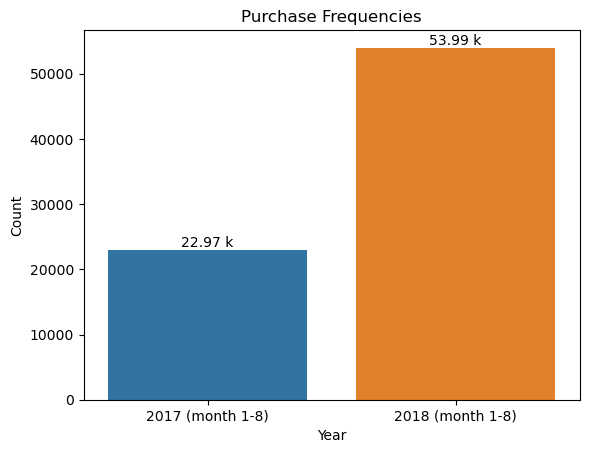

In [278]:
df_support = df_support[df_support['month'].between(1,8)][['year']]
ax = sns.countplot(data=df_support,x='year')


for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h/1e3, 2)} k'  for h in bar.datavalues])
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Purchase Frequencies')
ax.set_xticklabels(labels=['2017 (month 1-8)', '2018 (month 1-8)'])

plt.show()

#### **`4th RECOMMENDATION`**

There appears to be a significant increase in the number of transactions between 2017 and 2018, meaning that more orders are happening on the platform. Here we recommend that in 2019, we create a special seller app to improve the performance of the service on orders that continue to increase each year.

**Benefits for Sellers:**
- Faster response in answering customer questions that can increase conversion rates
- Analytical marketing for sellers is easier and can support their marketing efforts.

**Benefits for Company:**
- Easier communication with sellers, such as for stock notifications as mentioned earlier
- Reducing poor service from sellers that affects our reputation, especially for new users.

*FYI :*
*This was actually done by Olist in the real world, in May 2019 they released their own app for sellers.*

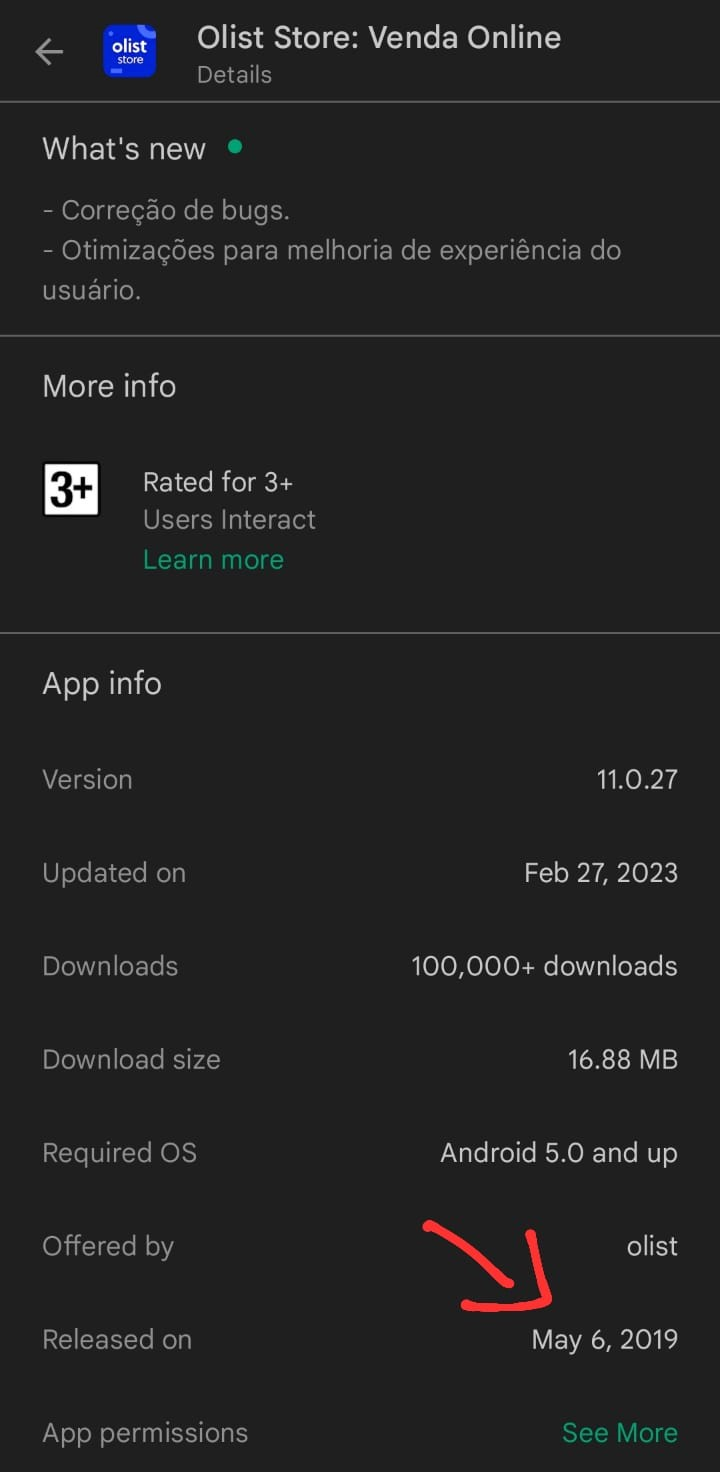

In [279]:
Image('olist appseller.jpg')

### **`Is There Any Other Potential That can be Used as Product Diversification?`**


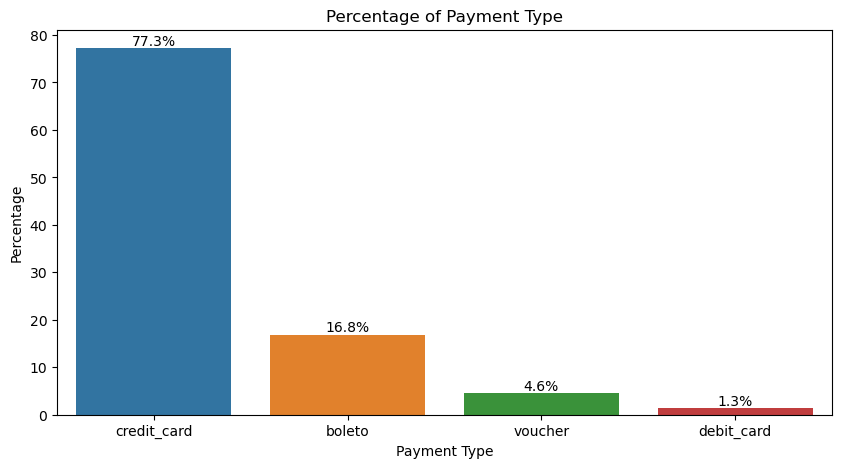

In [280]:
# Preparing the data to create a graph
df_support = df_orders.groupby(by='payment_type').sum()[['purchase']].reset_index().sort_values(by='purchase',ascending=False)
df_support['percentage'] = (df_support['purchase']/df_support['purchase'].sum())*100


# Creating a graph of the percentage of transaction types used in making purchases
plt.figure(figsize = (10,5))
ax = sns.barplot(data=df_support,x='payment_type',y='percentage')

for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f'{round(h, 1)}%' for h in bar.datavalues])

ax.set(xlabel='Payment Type', ylabel='Percentage',
       title='Percentage of Payment Type')

plt.show()

#### **`5th RECOMMENDATION`**

77% of customers have the habit of Buy Now Pay Later, we can open our own pay later service with a lower installment rate.

In the future, it is not impossible for us to diversify our products into financial services for transactions outside our platform.

---
## **Summary**

The prediction results of TIV for the next 4 months using the best estimator from the Elastic Net (Enet) Regression Model :

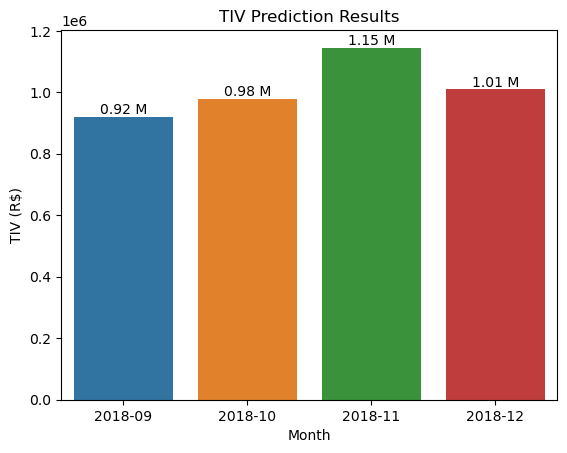

In [281]:
a= sns.barplot(data=df_future_month,x='date',y='pred')
for bar in a.containers:
    a.bar_label(bar, label_type='edge', labels=[f'{round(h/1e6, 2)} M'  for h in bar.datavalues])
plt.ylabel('TIV (R$)')
plt.xlabel('Month')
plt.title('TIV Prediction Results')

plt.show()

Based on the prediction results, The Marketing Team can determine the average benchmark for this year to decide on marketing budgets.

To achieve the predicted TIV, some business recommendations can be given such as :
1. Increasing ABS and user retention by providing discount vouchers
1. Improving user acquisition in cities that have potential (high population but low user acquisition rate)
1. Creating special campaigns based on specific days, and ensuring that the top-selling categories have enough stock
1. Enhancing seller services by creating an AppSellers
1. Diversifying payment products by using E-Wallet.